In [1]:
# Standard library imports
import json
import os
import pickle
import sqlite3
import time
import unittest
from datetime import datetime, timedelta
from pathlib import Path
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union
from unittest.mock import Mock, patch

# Third-party imports
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import plotly.graph_objects as go
import plotly.io as pio
import pytz
from plotly.subplots import make_subplots
from tvDatafeed import Interval, TvDatafeed

# Configure plotly renderer
pio.renderers.default = "notebook"

In [2]:
@dataclass
class Trade:
    datetime: datetime
    price: float
    quantity: float
    type: str  # 'buy' or 'sell'
    fee_percentage: float  # Fee in actual percentage (e.g., 0.05 for 0.05%)

    @property
    def fee_amount(self) -> float:
        """Calculate fee amount based on trade value and fee percentage"""
        trade_value = self.price * self.quantity
        return trade_value * (self.fee_percentage / 100)

class MarketDataManager:
    def __init__(self, db_path: str = "market_data.db", timezone: str = 'America/Los_Angeles', username: str = None, password: str = None):
        self.db_path = db_path
        self._tv = TvDatafeed(username=username, password=password)
        self.current_zone = timezone
        self._initialize_db()

    def _initialize_db(self) -> None:
        """Initialize the market data database"""
        with sqlite3.connect(self.db_path) as conn:
            conn.execute("""
                CREATE TABLE IF NOT EXISTS market_data (
                    symbol TEXT,
                    exchange TEXT,
                    datetime TEXT,
                    open REAL,
                    high REAL,
                    low REAL,
                    close REAL,
                    volume REAL,
                    PRIMARY KEY (symbol, exchange, datetime)
                )
            """)

            conn.execute("""
                CREATE TABLE IF NOT EXISTS last_update (
                    symbol TEXT,
                    exchange TEXT,
                    last_update TEXT,
                    PRIMARY KEY (symbol, exchange)
                )
            """)

    def _process_tv_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """Process TradingView data into standard format"""
        # Create a copy of the data
        processed_data = data.copy()

        # Convert index to datetime column
        processed_data['datetime'] = processed_data.index
        processed_data.reset_index(drop=True, inplace=True)

        # Select and order columns
        processed_data = processed_data[['datetime', 'open', 'high', 'low', 'close', 'volume']]

        # Convert timestamp to datetime
        processed_data['datetime'] = pd.to_datetime(processed_data['datetime'], unit='ms')

        # Handle timezone conversion
        processed_data['datetime'] = (processed_data['datetime']
                                      .dt.tz_localize(self.current_zone)
                                      .dt.tz_convert('UTC'))

        return processed_data

    def _check_data_availability(self, symbol: str, exchange: str = 'BINANCE') -> Tuple[bool, Optional[datetime]]:
        """
        Check if data is available and when it was last updated
        Returns: (is_data_available, last_update_time)
        """
        with sqlite3.connect(self.db_path) as conn:
            # Check if any data exists
            data_exists = conn.execute("""
                SELECT COUNT(*) FROM market_data 
                WHERE symbol = ? AND exchange = ?
            """, (symbol, exchange)).fetchone()[0] > 0

            # Get last update time
            last_update = conn.execute("""
                SELECT last_update FROM last_update 
                WHERE symbol = ? AND exchange = ?
            """, (symbol, exchange)).fetchone()

            last_update_time = None if not last_update else datetime.fromisoformat(last_update[0])

            return data_exists, last_update_time

    def update_symbol_data(self, symbol: str, exchange: str = 'BINANCE',
                           interval: Interval = Interval.in_daily) -> None:
        """Fetch and store latest market data for a symbol"""
        try:
            # Check data availability first
            data_exists, last_update = self._check_data_availability(symbol, exchange)

            # Calculate how many bars we need
            if data_exists and last_update:
                days_diff = (datetime.now(pytz.UTC) - last_update).days
                if days_diff <= 0:
                    # Data is up to date
                    return
                n_bars = max(days_diff + 1, 2)  # Always fetch at least 2 bars for overlap
            else:
                n_bars = 5000  # Initial fetch

            # Fetch data
            start_time = time.time()
            new_data = self._tv.get_hist(
                symbol=symbol,
                exchange=exchange,
                interval=interval,
                n_bars=n_bars
            )

            if new_data is None or new_data.empty:
                raise ValueError(f"No data received for {exchange}:{symbol}")

            new_data = self._process_tv_data(new_data)

            with sqlite3.connect(self.db_path) as conn:
                # Store the new data
                new_data.to_sql('market_data_temp', conn, index=False, if_exists='replace')

                # Insert new data, replacing any existing records
                conn.execute("""
                    INSERT OR REPLACE INTO market_data (symbol, exchange, datetime, open, high, low, close, volume)
                    SELECT ?, ?, datetime, open, high, low, close, volume 
                    FROM market_data_temp
                """, (symbol, exchange))

                # Update last update time
                conn.execute("""
                    INSERT OR REPLACE INTO last_update (symbol, exchange, last_update)
                    VALUES (?, ?, ?)
                """, (symbol, exchange, datetime.now(pytz.UTC).isoformat()))

                conn.execute("DROP TABLE market_data_temp")

            end_time = time.time()
            if end_time - start_time > 2:
                print(f"Warning: Updating {exchange}:{symbol} took {end_time-start_time:.2f} seconds")

        except Exception as e:
            print(f"Error updating {exchange}:{symbol}: {str(e)}")
            raise

    def get_current_price(self, symbol: str, exchange: str = 'BINANCE') -> Optional[float]:
        """
        Get the latest price for a symbol from the database
        Returns None if price cannot be fetched
        """
        try:
            with sqlite3.connect(self.db_path) as conn:
                result = conn.execute("""
                        SELECT close FROM market_data 
                        WHERE symbol = ? AND exchange = ?
                        ORDER BY datetime DESC LIMIT 1
                    """, (symbol, exchange)).fetchone()

            if not result:
                # If no data exists, try to fetch it
                try:
                    self.update_symbol_data(symbol, exchange)
                    return self.get_current_price(symbol, exchange)
                except Exception as e:
                    print(f"Error fetching data for {exchange}:{symbol}: {str(e)}")
                    return None

            return result[0]
        except Exception as e:
            print(f"Error getting current price for {exchange}:{symbol}: {str(e)}")
            return None

    def get_historical_data(self, symbol: str, exchange: str = 'BINANCE',
                            start_date: Optional[datetime] = None,
                            end_date: Optional[datetime] = None) -> pd.DataFrame:
        """Get historical price data for a symbol"""
        query = """
            SELECT datetime, open, high, low, close, volume 
            FROM market_data 
            WHERE symbol = ? AND exchange = ?
        """
        params = [symbol, exchange]

        if start_date:
            start_date = start_date.astimezone(pytz.UTC)
            query += " AND datetime >= ?"
            params.append(start_date.isoformat())
        if end_date:
            end_date = end_date.astimezone(pytz.UTC)
            query += " AND datetime <= ?"
            params.append(end_date.isoformat())

        query += " ORDER BY datetime"

        with sqlite3.connect(self.db_path) as conn:
            data = pd.read_sql_query(query, conn, params=params)

        if data.empty:
            # If no data exists, fetch it first
            self.update_symbol_data(symbol, exchange)
            return self.get_historical_data(symbol, exchange, start_date, end_date)

        # Convert datetime column to pandas datetime with UTC timezone
        data['datetime'] = pd.to_datetime(data['datetime']).dt.tz_convert(pytz.UTC)
        return data

    def get_external_benchmark_data(self, symbol: str, exchange: str = 'NYSE') -> pd.DataFrame:
        """
        Get data for external benchmarks (like SPY) that might be from different exchanges
        Returns normalized data in the same format as get_historical_data
        """
        # For stocks, we could integrate with another data provider
        # For now, we'll use a placeholder that could be extended later
        try:
            # Try to get data from your existing source first
            data = self.get_historical_data(symbol, exchange)
            if data.empty:
                raise ValueError(f"No data available for {exchange}:{symbol}")
            return data
        except Exception as e:
            print(f"Error fetching external benchmark {exchange}:{symbol}: {str(e)}")
            return pd.DataFrame()

    def get_aligned_data(self,
                         symbols: List[Union[str, Tuple[str, str]]],
                         start_date: Optional[datetime] = None,
                         end_date: Optional[datetime] = None,
                         value_type: str = 'close',
                         fill_method: str = 'ffill') -> pd.DataFrame:
        """
        Get aligned price data for multiple symbols in a single DataFrame.
        
        Args:
            symbols: List of symbols. Each symbol can be either:
                    - A string in format "EXCHANGE:SYMBOL" (e.g., "BINANCE:BTCUSDT")
                    - A tuple of (exchange, symbol) (e.g., ("BINANCE", "BTCUSDT"))
            start_date: Optional start date for the data
            end_date: Optional end date for the data
            value_type: Which OHLCV value to use ('open', 'high', 'low', 'close', 'volume')
            fill_method: Method to fill missing values ('ffill', 'bfill', 'none')
                        'ffill': Forward fill
                        'bfill': Backward fill
                        'none': Leave as NaN
        
        Returns:
            DataFrame with datetime index and columns for each symbol
        """
        # Validate value_type
        if value_type not in ['open', 'high', 'low', 'close', 'volume']:
            raise ValueError(f"Invalid value_type: {value_type}")

        # Process symbols into consistent format
        processed_symbols = []
        for symbol in symbols:
            if isinstance(symbol, str):
                if ':' not in symbol:
                    raise ValueError(f"Symbol string must be in format 'EXCHANGE:SYMBOL', got: {symbol}")
                exchange, sym = symbol.split(':')
                processed_symbols.append((exchange, sym))
            elif isinstance(symbol, (tuple, list)) and len(symbol) == 2:
                processed_symbols.append((symbol[0], symbol[1]))
            else:
                raise ValueError(f"Invalid symbol format: {symbol}")

        # Fetch data for each symbol
        dfs = []
        for exchange, symbol in processed_symbols:
            try:
                # Get historical data
                df = self.get_historical_data(symbol, exchange, start_date, end_date)
                if df.empty:
                    print(f"Warning: No data available for {exchange}:{symbol}")
                    continue

                # Extract the requested value type and rename the column
                df = df[['datetime', value_type]]
                df = df.rename(columns={value_type: f"{exchange}:{symbol}"})

                # Set datetime as index
                df.set_index('datetime', inplace=True)

                dfs.append(df)

            except Exception as e:
                print(f"Error fetching data for {exchange}:{symbol}: {str(e)}")
                continue

        if not dfs:
            return pd.DataFrame()

        # Merge all dataframes on datetime index
        aligned_df = pd.concat(dfs, axis=1)

        # Sort by datetime
        aligned_df.sort_index(inplace=True)

        # Handle missing values
        if fill_method == 'ffill':
            aligned_df.fillna(method='ffill', inplace=True)
        elif fill_method == 'bfill':
            aligned_df.fillna(method='bfill', inplace=True)
        # If fill_method is 'none', leave NaN values as is

        return aligned_df

    def get_returns_matrix(self,
                           symbols: List[Union[str, Tuple[str, str]]],
                           start_date: Optional[datetime] = None,
                           end_date: Optional[datetime] = None,
                           value_type: str = 'close',
                           fill_method: str = 'ffill',
                           returns_type: str = 'arithmetic') -> pd.DataFrame:
        """
        Get returns matrix for multiple symbols.
        
        Args:
            symbols: List of symbols (same format as get_aligned_data)
            start_date: Optional start date
            end_date: Optional end date
            value_type: Which OHLCV value to use
            fill_method: How to handle missing values
            returns_type: Type of returns to calculate ('arithmetic' or 'log')
        
        Returns:
            DataFrame with returns for each symbol
        """
        # Get aligned price data
        prices = self.get_aligned_data(
            symbols=symbols,
            start_date=start_date,
            end_date=end_date,
            value_type=value_type,
            fill_method=fill_method
        )

        if prices.empty:
            return pd.DataFrame()

        # Calculate returns
        if returns_type == 'arithmetic':
            returns = prices.pct_change()
        elif returns_type == 'log':
            returns = np.log(prices / prices.shift(1))
        else:
            raise ValueError(f"Invalid returns_type: {returns_type}")

        return returns

    def get_correlation_matrix(self,
                               symbols: List[Union[str, Tuple[str, str]]],
                               start_date: Optional[datetime] = None,
                               end_date: Optional[datetime] = None,
                               value_type: str = 'close',
                               fill_method: str = 'ffill',
                               returns_type: str = 'arithmetic',
                               correlation_type: str = 'pearson') -> pd.DataFrame:
        """
        Calculate correlation matrix for multiple symbols.
        
        Args:
            symbols: List of symbols (same format as get_aligned_data)
            start_date: Optional start date
            end_date: Optional end date
            value_type: Which OHLCV value to use
            fill_method: How to handle missing values
            returns_type: Type of returns to calculate
            correlation_type: Type of correlation ('pearson' or 'spearman')
        
        Returns:
            Correlation matrix DataFrame
        """
        # Get returns matrix
        returns = self.get_returns_matrix(
            symbols=symbols,
            start_date=start_date,
            end_date=end_date,
            value_type=value_type,
            fill_method=fill_method,
            returns_type=returns_type
        )

        if returns.empty:
            return pd.DataFrame()

        # Calculate correlation matrix
        if correlation_type not in ['pearson', 'spearman']:
            raise ValueError(f"Invalid correlation_type: {correlation_type}")

        return returns.corr(method=correlation_type)

class PortfolioUnit:
    def __init__(self, initial_value: float = 1000000):
        self.initial_value = initial_value  # Store initial value for historical tracking
        self.total_units = initial_value  # Initial units at $1 each
        self.unit_price = 1.0  # Start at $1 per unit
        self.cash_flows = []
        # Initialize cash_balance with initial_value since we start with all cash
        self.cash_balance = initial_value

    def add_cash_flow(self, amount: float, timestamp: datetime):
        """Record a cash flow (positive for deposits, negative for withdrawals)"""
        if amount != 0:
            if amount > 0:  # Deposit
                new_units = amount / self.unit_price
                self.total_units += new_units
                self.cash_balance += amount
            else:  # Withdrawal
                if abs(amount) > self.cash_balance:
                    raise ValueError(f"Insufficient cash balance ({self.cash_balance}) for withdrawal of {abs(amount)}")
                units_reduced = abs(amount) / self.unit_price
                self.total_units -= units_reduced
                self.cash_balance += amount  # amount is negative, so this reduces cash_balance

            self.cash_flows.append({
                'timestamp': timestamp,
                'amount': amount,
                'unit_price': self.unit_price,
                'units_changed': new_units if amount > 0 else -units_reduced
            })

    def update_unit_price(self, total_portfolio_value: float):
        """
        Update unit price based on total portfolio value
        total_portfolio_value should NOT include cash_balance as it's already part of total_units
        """
        if self.total_units > 0:
            total_assets = total_portfolio_value + self.cash_balance
            self.unit_price = total_assets / self.total_units

    def get_total_value(self) -> float:
        """Get total value of all units including cash"""
        return self.total_units * self.unit_price

    def get_performance(self) -> float:
        """Get performance as percentage change in unit price"""
        return ((self.unit_price - 1.0) / 1.0) * 100

class PortfolioMetrics:
    def __init__(self, portfolio):
        self.portfolio = portfolio

    def calculate_drawdown(self, prices: pd.Series) -> Tuple[float, float]:
        """
        Calculate maximum drawdown and current drawdown from a price series
        Returns: (max_drawdown_percentage, current_drawdown_percentage)
        """
        if len(prices) < 2 or prices.isna().all() or (prices == 0).all():
            return 0.0, 0.0

        # Remove any zero or NaN values
        prices = prices.replace(0, np.nan).dropna()

        if len(prices) < 2:
            return 0.0, 0.0

        # Calculate running maximum
        running_max = prices.expanding().max()
        drawdown = (prices - running_max) / running_max * 100

        # Handle potential NaN values
        max_drawdown = abs(drawdown.min()) if not pd.isna(drawdown.min()) else 0.0
        current_drawdown = abs(drawdown.iloc[-1]) if not pd.isna(drawdown.iloc[-1]) else 0.0

        return max_drawdown, current_drawdown

    def calculate_returns(self, prices: pd.Series) -> pd.Series:
        """Calculate daily returns from price series"""
        return prices.pct_change().fillna(0)

    def calculate_period_return(self, prices: pd.Series, days: int) -> float:
        """Calculate return over a specific period in percentage"""
        if len(prices) < 2:  # Need at least 2 points for return calculation
            return 0.0

        # Get start and end prices
        start_price = prices.iloc[-min(len(prices), days)]
        end_price = prices.iloc[-1]

        # Handle zero or NaN start price
        if pd.isna(start_price) or start_price == 0 or pd.isna(end_price):
            return 0.0

        return ((end_price - start_price) / start_price) * 100

    def calculate_sharpe_ratio(self, returns: pd.Series, risk_free_rate: float = 0.02) -> float:
        """
        Calculate annualized Sharpe ratio
        risk_free_rate should be in decimal form (e.g., 0.02 for 2%)
        """
        if len(returns) < 2:
            return 0.0

        daily_rf_rate = (1 + risk_free_rate) ** (1/365) - 1
        excess_returns = returns - daily_rf_rate

        if excess_returns.std() == 0:
            return 0.0

        annualized_sharpe = np.sqrt(365) * (excess_returns.mean() / excess_returns.std())
        return annualized_sharpe

    def calculate_sortino_ratio(self, returns: pd.Series, risk_free_rate: float = 0.02) -> float:
        """
        Calculate annualized Sortino ratio
        risk_free_rate should be in decimal form (e.g., 0.02 for 2%)
        """
        if len(returns) < 2:
            return 0.0

        daily_rf_rate = (1 + risk_free_rate) ** (1/365) - 1
        excess_returns = returns - daily_rf_rate

        # Calculate downside deviation (only negative returns)
        downside_returns = excess_returns[excess_returns < 0]

        if len(downside_returns) == 0 or downside_returns.std() == 0:
            return 0.0

        annualized_sortino = np.sqrt(365) * (excess_returns.mean() / downside_returns.std())
        return annualized_sortino

    def calculate_efficient_frontier(self, num_portfolios: int = 1000, risk_free_rate: float = 0.02) -> pd.DataFrame:
        """Calculate efficient frontier points"""
        # Get historical returns for all active positions
        position_returns = {}
        active_positions = self.portfolio.get_active_positions()

        for pos_key, position in active_positions.items():
            hist_data = position.get_historical_data(
                start_date=datetime.now(pytz.UTC) - timedelta(days=365)
            )
            if not hist_data.empty:
                position_returns[pos_key] = hist_data['close'].pct_change().dropna()

        if not position_returns:
            return pd.DataFrame()

        returns_df = pd.DataFrame(position_returns)
        mean_returns = returns_df.mean() * 252  # Annualize returns
        cov_matrix = returns_df.cov() * 252     # Annualize covariance

        # Generate random portfolio weights
        results = []
        for _ in range(num_portfolios):
            weights = np.random.random(len(active_positions))
            weights /= np.sum(weights)

            # Calculate portfolio metrics
            ret = np.sum(mean_returns * weights)
            vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            sharpe = (ret - risk_free_rate) / vol if vol > 0 else 0

            results.append({
                'Return': ret * 100,  # Convert to percentage
                'Volatility': vol * 100,
                'Sharpe': sharpe,
                'Weights': dict(zip(active_positions.keys(), weights))
            })

        results_df = pd.DataFrame(results)

        # Find optimal portfolios
        max_sharpe_idx = results_df['Sharpe'].idxmax()
        min_vol_idx = results_df['Volatility'].idxmin()

        # Add current portfolio weights
        current_weights = {
            pos_key: pos.get_position_value() / self.portfolio.get_total_portfolio_value()
            for pos_key, pos in active_positions.items()
        }
        current_ret = np.sum(mean_returns * list(current_weights.values())) * 100
        current_vol = np.sqrt(
            np.dot(
                list(current_weights.values()),
                np.dot(cov_matrix, list(current_weights.values()))
            )
        ) * 100

        results_df['Type'] = 'Random'
        results_df.loc[max_sharpe_idx, 'Type'] = 'Maximum Sharpe'
        results_df.loc[min_vol_idx, 'Type'] = 'Minimum Volatility'

        # Add current portfolio point
        current_point = pd.Series({
            'Return': current_ret,
            'Volatility': current_vol,
            'Sharpe': (current_ret/100 - risk_free_rate)/(current_vol/100),
            'Weights': current_weights,
            'Type': 'Current Portfolio'
        })

        results_df = pd.concat([results_df, pd.DataFrame([current_point])])
        return results_df

    def calculate_var(self, confidence_level=0.95, lookback_days=365) -> float:
        """Calculate Value at Risk"""
        total_value = self.portfolio.get_total_portfolio_value()
        daily_returns = []

        for position in self.portfolio.positions.values():
            hist_data = position.get_historical_data(
                start_date=datetime.now(pytz.UTC) - timedelta(days=lookback_days)
            )
            if not hist_data.empty:
                position_returns = hist_data['close'].pct_change().dropna()
                position_value = position.get_position_value()
                position_weight = position_value / total_value if total_value > 0 else 0
                daily_returns.append(position_returns * position_weight)

        if daily_returns:
            portfolio_returns = pd.concat(daily_returns, axis=1).sum(axis=1)
            var = portfolio_returns.quantile(1 - confidence_level)
            return abs(var * total_value)
        return 0.0

    def calculate_correlations(self, method='pearson', lookback_days=365) -> pd.DataFrame:
        """Calculate correlation matrix between positions using either linear or non-linear method"""
        position_returns = {}

        for symbol, position in self.portfolio.positions.items():
            hist_data = position.get_historical_data(
                start_date=datetime.now(pytz.UTC) - timedelta(days=lookback_days)
            )
            if not hist_data.empty:
                position_returns[symbol] = hist_data['close'].pct_change().dropna()

        if not position_returns:
            return pd.DataFrame()

        df_returns = pd.DataFrame(position_returns)
        return df_returns.corr(method=method)

    def calculate_contribution_to_return(self) -> Dict[str, Dict[str, float]]:
        """Calculate how much each position contributed to total return"""
        total_return = self.get_portfolio_summary()['total_pnl']
        contributions = {}
        total_portfolio_value = self.portfolio.get_total_portfolio_value()

        if total_portfolio_value == 0:
            return {}

        for pos_key, position in self.portfolio.positions.items():
            position_value = position.get_position_value()
            position_return = position.get_unrealized_pnl()
            weight = position_value / total_portfolio_value

            # Avoid division by zero
            if total_return != 0:
                contribution = (position_return * weight) / total_return * 100
            else:
                contribution = 0

            contributions[pos_key] = {
                'weight': weight * 100,
                'return': (position_return / position_value * 100) if position_value > 0 else 0,
                'contribution': contribution
            }

        return contributions

    def get_portfolio_summary(self) -> Dict[str, float]:
        """
        Get comprehensive portfolio-level metrics
        Returns a dictionary with various portfolio performance metrics
        """
        summary = {
            'current_value': 0.0,
            'total_investment': 0.0,
            'total_pnl': 0.0,
            'pnl_percentage': 0.0,
            'max_drawdown': 0.0,
            'current_drawdown': 0.0,
            'sharpe_ratio': 0.0,
            'sortino_ratio': 0.0,
            '7d_return': 0.0,
            '1m_return': 0.0,
            '4m_return': 0.0,
            '1y_return': 0.0,
            'daily_volatility': 0.0,
            'annualized_volatility': 0.0
        }

        # Get active positions
        active_positions = self.portfolio.get_active_positions()
        if not active_positions:
            return summary

        # Calculate basic portfolio values
        total_investment = sum(pos.average_entry * pos.quantity for pos in active_positions.values())
        current_value = sum(pos.get_position_value() for pos in active_positions.values())

        # Get historical data for all positions
        end_date = datetime.now(pytz.UTC)
        start_date = end_date - timedelta(days=365)
        historical_values = []

        for position in active_positions.values():
            try:
                historical_data = position.get_historical_data(start_date=start_date)
                if not historical_data.empty:
                    historical_data['value'] = historical_data['close'] * position.quantity
                    historical_data = historical_data[['datetime', 'value']].copy()
                    historical_values.append(historical_data)
            except Exception as e:
                print(f"Error processing historical data for {position.exchange}:{position.symbol}: {str(e)}")
                continue

        if not historical_values:
            summary.update({
                'current_value': current_value,
                'total_investment': total_investment,
                'total_pnl': current_value - total_investment,
                'pnl_percentage': ((current_value - total_investment) / total_investment * 100) if total_investment > 0 else 0.0
            })
            return summary

        # Combine all historical values
        all_values = pd.concat(historical_values)
        portfolio_daily_values = all_values.groupby('datetime')['value'].sum()
        portfolio_daily_values = portfolio_daily_values.sort_index()

        if len(portfolio_daily_values) < 2:
            summary.update({
                'current_value': current_value,
                'total_investment': total_investment,
                'total_pnl': current_value - total_investment,
                'pnl_percentage': ((current_value - total_investment) / total_investment * 100) if total_investment > 0 else 0.0
            })
            return summary

        # Calculate portfolio metrics
        portfolio_daily_returns = self.calculate_returns(portfolio_daily_values)
        max_dd, current_dd = self.calculate_drawdown(portfolio_daily_values)

        # Calculate period returns
        week_return = self.calculate_period_return(portfolio_daily_values, 7)
        month_return = self.calculate_period_return(portfolio_daily_values, 30)
        quarter_return = self.calculate_period_return(portfolio_daily_values, 120)
        year_return = self.calculate_period_return(portfolio_daily_values, 365)

        # Calculate risk metrics
        sharpe = self.calculate_sharpe_ratio(portfolio_daily_returns)
        sortino = self.calculate_sortino_ratio(portfolio_daily_returns)
        daily_vol = portfolio_daily_returns.std() * 100
        annual_vol = daily_vol * np.sqrt(252)

        return {
            'current_value': current_value,
            'total_investment': total_investment,
            'total_pnl': current_value - total_investment,
            'pnl_percentage': ((current_value - total_investment) / total_investment * 100) if total_investment > 0 else 0.0,
            'max_drawdown': max_dd,
            'current_drawdown': current_dd,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino,
            '7d_return': week_return,
            '1m_return': month_return,
            '4m_return': quarter_return,
            '1y_return': year_return,
            'daily_volatility': daily_vol,
            'annualized_volatility': annual_vol
        }

class Position:
    def __init__(self, symbol: str,
                 exchange: str = 'BINANCE',
                 market_data: Optional[MarketDataManager] = None,
                 portfolio_unit_tracker: Optional[PortfolioUnit] = None):
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = 0
        self.average_entry = 0
        self.trades: List[Trade] = []
        self.realized_pnl = 0
        self.market_data = market_data
        self.portfolio_unit_tracker = portfolio_unit_tracker  # Store reference to portfolio's unit tracker

    def add_to_position(self, quantity: float, price: float, datetime: datetime, fee_percentage: float = 0.05) -> None:
        """Add to existing position or create new position"""
        if quantity <= 0:
            raise ValueError("Quantity must be positive for adding to position")

        trade = Trade(
            datetime=datetime,
            price=price,
            quantity=quantity,
            type='buy',
            fee_percentage=fee_percentage
        )

        # Calculate total cost including fees
        trade_value = price * quantity
        fee_amount = trade_value * (fee_percentage / 100)
        total_cost = trade_value + fee_amount

        # Update portfolio unit tracker (this is a cash outflow)
        if self.portfolio_unit_tracker:
            self.portfolio_unit_tracker.add_cash_flow(-total_cost, datetime)

        # Update average entry
        if self.quantity > 0:
            self.average_entry = ((self.quantity * self.average_entry) + total_cost) / (self.quantity + quantity)
        else:
            self.average_entry = total_cost / quantity

        self.quantity += quantity
        self.trades.append(trade)

    def reduce_position(self, quantity: float, price: float, datetime: datetime, fee_percentage: float = 0.05) -> float:
        """Reduce position and return realized PnL"""
        if quantity <= 0:
            raise ValueError("Quantity must be positive for reducing position")
        if quantity > self.quantity:
            raise ValueError("Cannot reduce more than current position size")

        trade = Trade(
            datetime=datetime,
            price=price,
            quantity=quantity,
            type='sell',
            fee_percentage=fee_percentage
        )

        # Calculate trade value and fees
        trade_value = price * quantity
        fee_amount = trade_value * (fee_percentage / 100)
        net_value = trade_value - fee_amount

        # Update unit tracker with the positive cash flow (money coming in)
        if self.portfolio_unit_tracker:
            self.portfolio_unit_tracker.add_cash_flow(net_value, datetime)

        # Calculate realized PnL
        cost_basis = self.average_entry * quantity
        realized_pnl = net_value - cost_basis

        self.realized_pnl += realized_pnl
        self.quantity -= quantity
        self.trades.append(trade)

        return realized_pnl

    def get_position_value(self) -> float:
        """
        Get current position value
        Returns 0 if current price cannot be determined
        """
        current_price = self.get_current_price()
        if current_price is None:
            return 0.0
        return self.quantity * current_price

    def get_unrealized_pnl(self) -> float:
        """
        Calculate unrealized PnL based on current market price
        Returns 0 if current price cannot be determined
        """
        current_price = self.get_current_price()
        if current_price is None or self.quantity == 0:
            return 0.0
        market_value = self.quantity * current_price
        cost_basis = self.quantity * self.average_entry
        return market_value - cost_basis

    def get_trading_history(self) -> pd.DataFrame:
        """Return trading history as a pandas DataFrame"""
        if not self.trades:
            return pd.DataFrame()

        return pd.DataFrame([{
            'datetime': trade.datetime,
            'price': trade.price,
            'quantity': trade.quantity,
            'type': trade.type,
            'fee_percentage': trade.fee_percentage,
            'fee_amount': trade.fee_amount,
            'total_cost': (trade.price * trade.quantity) + trade.fee_amount
        } for trade in self.trades])

    def get_current_price(self) -> Optional[float]:
        """
        Get current market price from market data manager
        Returns None if price cannot be fetched
        """
        if self.market_data is None:
            return None
        return self.market_data.get_current_price(self.symbol, self.exchange)

    def get_historical_quantity(self, date: datetime) -> float:
        """Get the position quantity at a specific point in time"""
        quantity = 0
        for trade in sorted(self.trades, key=lambda x: x.datetime):
            if trade.datetime > date:
                break
            if trade.type == 'buy':
                quantity += trade.quantity
            else:  # sell
                quantity -= trade.quantity
        return quantity

    def get_historical_data(self, start_date: Optional[datetime] = None,
                            end_date: Optional[datetime] = None) -> pd.DataFrame:
        """Get historical price data with position sizes"""
        if self.market_data is None:
            raise ValueError("Market data manager not initialized")

        data = self.market_data.get_historical_data(
            self.symbol,
            self.exchange,
            start_date,
            end_date
        )

        if data.empty:
            return data

        # Add position quantities over time
        data['quantity'] = data['datetime'].apply(self.get_historical_quantity)
        data['value'] = data['close'] * data['quantity']

        return data

class Portfolio:
    def __init__(self, storage_path: str = "portfolio.db",
                 market_data_path: str = "market_data.db",
                 initial_deposit: float = 1000000,
                 username: str = None, password: str = None):
        self.storage = PortfolioStorage(storage_path)
        self.market_data = MarketDataManager(market_data_path, username=username, password=password)
        self.positions: Dict[str, Position] = {}
        self.unit_tracker = PortfolioUnit(initial_deposit)
        self.metrics = PortfolioMetrics(self)  # Initialize metrics calculator
        self._load_portfolio()

    def deposit(self, amount: float, timestamp: datetime):
        """Add new capital to the portfolio"""
        self.unit_tracker.add_cash_flow(amount, timestamp)

    def withdraw(self, amount: float, timestamp: datetime):
        """Withdraw capital from the portfolio"""
        self.unit_tracker.add_cash_flow(-amount, timestamp)

    def _load_portfolio(self) -> None:
        """Load all positions and trades from the database"""
        with sqlite3.connect(self.storage.db_path) as conn:
            positions = conn.execute("""
                SELECT symbol, exchange FROM positions
            """).fetchall()

            for symbol, exchange in positions:
                position = self.storage.load_position(symbol, exchange)
                if position:
                    position.market_data = self.market_data
                    self.positions[f"{exchange}:{symbol}"] = position

    def list_positions(self) -> List[str]:
        """Return a list of all position identifiers in {exchange}:{symbol} format"""
        with sqlite3.connect(self.storage.db_path) as conn:
            positions = conn.execute("""
                SELECT DISTINCT exchange, symbol FROM positions
            """).fetchall()

        return [f"{exchange}:{symbol}" for exchange, symbol in positions]

    def get_position(self, symbol: str, exchange: Optional[str] = None) -> Union[Position, Dict[str, Position], None]:
        """
        Get position(s) for a symbol, optionally filtered by exchange.

        Args:
            symbol: The trading symbol
            exchange: Optional exchange name. If None, returns all positions for the symbol across exchanges

        Returns:
            - If exchange is specified: Returns a single Position or None
            - If exchange is None: Returns a dict of {exchange: Position} for all exchanges with this symbol
        """
        if exchange:
            position_key = f"{exchange}:{symbol}"
            return self.positions.get(position_key)

        # If no exchange specified, return all positions for this symbol across exchanges
        symbol_positions = {
            key.split(':')[0]: pos  # exchange as key
            for key, pos in self.positions.items()
            if key.split(':')[1] == symbol
        }

        return symbol_positions if symbol_positions else None

    def get_active_positions(self, exchange: Optional[str] = None) -> Dict[str, Position]:
        """
        Return positions with non-zero quantity, optionally filtered by exchange.
        Returns dict with keys in {exchange}:{symbol} format
        """
        active = {
            key: pos for key, pos in self.positions.items()
            if pos.quantity > 0 and (not exchange or key.split(':')[0] == exchange)
        }
        return active

    def get_position_trading_history(self, symbol: str, exchange: str = 'BINANCE') -> pd.DataFrame:
        """Get trading history for a specific position"""
        position = self.get_position(symbol, exchange)
        if position is None:
            return pd.DataFrame()
        return position.get_trading_history()

    def get_total_portfolio_value(self) -> float:
        """Calculate total portfolio value including all positions and cash"""
        position_value = sum(pos.get_position_value() for pos in self.positions.values())
        return position_value + self.unit_tracker.cash_balance

    def update_portfolio_units(self):
        """Update unit prices based on current portfolio value"""
        position_value = sum(pos.get_position_value() for pos in self.positions.values())
        # Note: Don't include cash_balance here as it's handled inside update_unit_price
        self.unit_tracker.update_unit_price(position_value)

    def add_position(self, symbol: str, exchange: str = 'BINANCE') -> None:
        """Add a new position to the portfolio"""
        position_key = f"{exchange}:{symbol}"

        if position_key not in self.positions:
            position = self.storage.load_position(symbol, exchange)
            if position is None:
                position = Position(symbol, exchange, self.market_data, self.unit_tracker)
            else:
                position.market_data = self.market_data
                position.portfolio_unit_tracker = self.unit_tracker
            self.positions[position_key] = position

            # Update market data if needed
            data_exists, last_update = self.market_data._check_data_availability(symbol, exchange)
            if not data_exists or (last_update and (datetime.now(pytz.UTC) - last_update).days >= 1):
                self.market_data.update_symbol_data(symbol, exchange)

            # Update unit prices after position changes
            self.update_portfolio_units()

    def get_position_summary(self, exchange: Optional[str] = None) -> pd.DataFrame:
        """Get an enhanced summary of all positions as a DataFrame"""
        summaries = []
        for pos_key, position in self.positions.items():
            pos_exchange, symbol = pos_key.split(':')

            if exchange and pos_exchange != exchange:
                continue

            # Get historical data for calculations
            historical_data = position.get_historical_data(
                start_date=datetime.now(pytz.UTC) - timedelta(days=365)
            )

            if historical_data.empty:
                continue

            prices = historical_data['close']

            # Calculate basic metrics
            current_price = position.get_current_price() or 0.0
            market_value = position.get_position_value()
            unrealized_pnl = position.get_unrealized_pnl()

            # Calculate advanced metrics using PortfolioMetrics
            max_dd, current_dd = self.metrics.calculate_drawdown(prices)
            returns = self.metrics.calculate_returns(prices)

            # Calculate period returns using PortfolioMetrics
            week_return = self.metrics.calculate_period_return(prices, 7)
            month_return = self.metrics.calculate_period_return(prices, 30)
            quarter_return = self.metrics.calculate_period_return(prices, 120)
            year_return = self.metrics.calculate_period_return(prices, 365)

            # Calculate PnL percentage
            total_investment = position.average_entry * position.quantity
            pnl_percentage = ((market_value - total_investment) / total_investment * 100) if total_investment > 0 else 0

            summaries.append({
                'exchange': pos_exchange,
                'symbol': symbol,
                'quantity': position.quantity,
                'average_entry': position.average_entry,
                'current_price': current_price,
                'market_value': market_value,
                'realized_pnl': position.realized_pnl,
                'unrealized_pnl': unrealized_pnl,
                'total_pnl': position.realized_pnl + unrealized_pnl,
                'pnl_percentage': pnl_percentage,
                'max_drawdown': max_dd,
                'current_drawdown': current_dd,
                '7d_return': week_return,
                '1m_return': month_return,
                '4m_return': quarter_return,
                '1y_return': year_return
            })

        return pd.DataFrame(summaries)

    # Delegate all metrics calculations to the PortfolioMetrics class
    def get_portfolio_summary(self) -> Dict[str, float]:
        """Get comprehensive portfolio-level metrics"""
        return self.metrics.get_portfolio_summary()

    def calculate_efficient_frontier(self, num_portfolios: int = 1000, risk_free_rate: float = 0.02) -> pd.DataFrame:
        """Calculate efficient frontier points"""
        return self.metrics.calculate_efficient_frontier(num_portfolios, risk_free_rate)

    def calculate_var(self, confidence_level: float = 0.95, lookback_days: int = 365) -> float:
        """Calculate Value at Risk"""
        return self.metrics.calculate_var(confidence_level, lookback_days)

    def calculate_correlations(self, method: str = 'pearson', lookback_days: int = 365) -> pd.DataFrame:
        """Calculate correlation matrix between positions"""
        return self.metrics.calculate_correlations(method, lookback_days)

    def calculate_contribution_to_return(self) -> Dict[str, Dict[str, float]]:
        """Calculate how much each position contributed to total return"""
        return self.metrics.calculate_contribution_to_return()

class PortfolioStorage:
    def __init__(self, db_path: str = "portfolio.db"):
        self.db_path = db_path
        self._initialize_db()

    def _initialize_db(self) -> None:
        """Create database tables if they don't exist"""
        with sqlite3.connect(self.db_path) as conn:
            conn.execute("""
                CREATE TABLE IF NOT EXISTS positions (
                    symbol TEXT,
                    exchange TEXT,
                    quantity REAL,
                    average_entry REAL,
                    realized_pnl REAL,
                    PRIMARY KEY (symbol, exchange)
                )
            """)

            conn.execute("""
                CREATE TABLE IF NOT EXISTS trades (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    symbol TEXT,
                    exchange TEXT,
                    datetime TEXT,
                    price REAL,
                    quantity REAL,
                    type TEXT,
                    fee_percentage REAL,
                    FOREIGN KEY (symbol, exchange) REFERENCES positions (symbol, exchange),
                    UNIQUE(symbol, exchange, datetime, price, quantity, type)
                )
            """)


            conn.execute("""
                CREATE TABLE IF NOT EXISTS portfolio_snapshots (
                    timestamp TEXT,
                    total_value REAL,
                    realized_pnl REAL,
                    unrealized_pnl REAL
                )
            """)

    def save_position(self, position: Position) -> None:
        """Save position state to database with updated Trade structure"""
        with sqlite3.connect(self.db_path) as conn:
            conn.execute("""
                INSERT OR REPLACE INTO positions 
                (symbol, exchange, quantity, average_entry, realized_pnl)
                VALUES (?, ?, ?, ?, ?)
            """, (position.symbol, position.exchange, position.quantity,
                  position.average_entry, position.realized_pnl))

            # Save trades with updated fee structure
            for trade in position.trades:
                conn.execute("""
                    INSERT OR IGNORE INTO trades 
                    (symbol, exchange, datetime, price, quantity, type, fee_percentage)
                    VALUES (?, ?, ?, ?, ?, ?, ?)
                """, (position.symbol, position.exchange, trade.datetime.isoformat(),
                      trade.price, trade.quantity, trade.type, trade.fee_percentage))

    def load_position(self, symbol: str, exchange: str) -> Optional[Position]:
        """Load position from database with updated Trade structure"""
        with sqlite3.connect(self.db_path) as conn:
            # Load position data
            position_data = conn.execute("""
                SELECT quantity, average_entry, realized_pnl
                FROM positions 
                WHERE symbol = ? AND exchange = ?
            """, (symbol, exchange)).fetchone()

            if not position_data:
                return None

            position = Position(symbol, exchange)
            position.quantity = position_data[0]
            position.average_entry = position_data[1]
            position.realized_pnl = position_data[2]

            # Load trades with updated fee structure
            trades = conn.execute("""
                SELECT datetime, price, quantity, type, fee_percentage
                FROM trades 
                WHERE symbol = ? AND exchange = ?
                ORDER BY datetime
            """, (symbol, exchange)).fetchall()

            position.trades = [
                Trade(
                    datetime=datetime.fromisoformat(trade[0]),
                    price=trade[1],
                    quantity=trade[2],
                    type=trade[3],
                    fee_percentage=trade[4]
                )
                for trade in trades
            ]

            return position

class PortfolioVisualizer:
    def __init__(self, portfolio: Portfolio):
        self.portfolio = portfolio
        self.colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
        ]
        # Initialize color mapping for symbols
        self.color_map = self._initialize_color_map()

    def _initialize_color_map(self) -> Dict[str, str]:
        """Create a consistent color mapping for all symbols"""
        symbols = sorted(list(self.portfolio.positions.keys()))  # Get all position keys
        color_map = {
            'Portfolio': self.colors[0],  # Portfolio always gets first color
            'Cash': '#808080',  # Cash gets gray
        }

        # Assign colors to symbols
        for i, symbol in enumerate(symbols):
            color_map[symbol] = self.colors[(i + 1) % len(self.colors)]

        return color_map

    def prepare_portfolio_data(self, start_date: Optional[datetime] = None,
                               end_date: Optional[datetime] = None,
                               benchmark_identifier: Optional[str] = None) -> Dict[str, Any]:
        """Prepare portfolio data for visualization with correct performance calculation"""
        if start_date is None:
            start_date = datetime.now(pytz.UTC) - timedelta(days=365)
        if end_date is None:
            end_date = datetime.now(pytz.UTC)

        # Get active positions
        active_positions = self.portfolio.get_active_positions()
        initial_portfolio_value = self.portfolio.unit_tracker.initial_value

        # Get all trades sorted by date
        all_trades = []
        for pos_key, position in active_positions.items():
            all_trades.extend(position.trades)
        all_trades.sort(key=lambda x: x.datetime)

        # Initialize data structures for storing position and price histories
        position_histories = []
        symbol_prices = []

        # Process each active position
        for pos_key, position in active_positions.items():
            try:
                hist_data = position.get_historical_data(start_date=start_date, end_date=end_date)
                if not hist_data.empty:
                    # Store and calculate price performance data starting from position entry
                    price_data = hist_data[['datetime', 'close']].copy()
                    price_data['datetime'] = pd.to_datetime(price_data['datetime'])

                    # Get the first trade for this position
                    first_trade = min(position.trades, key=lambda x: x.datetime) if position.trades else None

                    if first_trade:
                        # Create entry point data point with 0% performance
                        entry_data = pd.DataFrame([{
                            'datetime': first_trade.datetime,
                            'close': first_trade.price,
                            'symbol_performance': 0.0,
                            'symbol': position.symbol
                        }])

                        # Get data after entry and calculate performance
                        future_data = price_data[price_data['datetime'] > first_trade.datetime].copy()
                        if not future_data.empty:
                            future_data['symbol_performance'] = ((future_data['close'] / first_trade.price) - 1) * 100
                            future_data['symbol'] = position.symbol

                            # Combine entry point with future data
                            price_data = pd.concat([entry_data, future_data])
                            symbol_prices.append(price_data)

                    # Calculate position value and store position history
                    position_data = hist_data.copy()
                    first_trade = min(position.trades, key=lambda x: x.datetime) if position.trades else None

                    if first_trade:
                        position_data['entry_date'] = first_trade.datetime
                        position_data['entry_price'] = first_trade.price
                        position_data['position_active'] = position_data['datetime'] >= first_trade.datetime
                        position_data['quantity'] = position.quantity
                        position_data['value'] = np.where(
                            position_data['position_active'],
                            position.quantity * position_data['close'],
                            0
                        )
                        position_data['symbol'] = position.symbol
                        position_histories.append(position_data)

            except Exception as e:
                print(f"Error processing historical data for {pos_key}: {str(e)}")
                continue

        if not position_histories:
            return {}

        # Combine all position histories and symbol prices
        all_values = pd.concat(position_histories)
        all_prices = pd.concat(symbol_prices) if symbol_prices else pd.DataFrame()

        # Calculate portfolio daily values
        portfolio_daily = all_values.groupby('datetime')[['value']].sum().reset_index()

        # Process cash flows and calculate portfolio performance
        cash_flows = sorted(self.portfolio.unit_tracker.cash_flows, key=lambda x: x['timestamp'])
        performance_data = []
        current_cash = initial_portfolio_value

        for idx, row in portfolio_daily.iterrows():
            date = row['datetime']

            # Process cash flows up to this date
            while cash_flows and cash_flows[0]['timestamp'] <= date:
                flow = cash_flows.pop(0)
                current_cash += flow['amount']

            total_value = row['value'] + current_cash

            # Calculate performance
            if all_trades and date >= all_trades[0].datetime:
                performance = ((total_value - initial_portfolio_value) / initial_portfolio_value * 100)
            else:
                performance = 0

            performance_data.append({
                'datetime': date,
                'total_value': total_value,
                'position_value': row['value'],
                'cash': current_cash,
                'performance': performance
            })

        portfolio_daily = pd.DataFrame(performance_data)

        # Calculate portfolio weights
        portfolio_daily['portfolio_total'] = portfolio_daily['position_value'] + portfolio_daily['cash']
        portfolio_daily['position_weight'] = (portfolio_daily['position_value'] /
                                              portfolio_daily['portfolio_total'] * 100)
        portfolio_daily['cash_weight'] = portfolio_daily['cash'] / portfolio_daily['portfolio_total'] * 100

        # Prepare symbol performance data
        symbol_data = []
        for symbol, group in all_prices.groupby('symbol'):
            # Ensure data is properly sorted by datetime
            group = group.sort_values('datetime')
            symbol_data.append({
                'symbol': symbol,
                'historicalValues': group[['datetime', 'symbol_performance']].to_dict('records')
            })

        # Get portfolio summary
        portfolio_summary = self.portfolio.get_portfolio_summary()

        # Process benchmark if provided
        benchmark_data = None
        if benchmark_identifier:
            try:
                exchange, symbol = benchmark_identifier.split(':')
                benchmark_data = self.portfolio.market_data.get_historical_data(
                    symbol,
                    exchange,
                    start_date,
                    end_date
                )
                if not benchmark_data.empty:
                    first_price = benchmark_data['close'].iloc[0]
                    benchmark_data['performance'] = ((benchmark_data['close'] / first_price) - 1) * 100
            except Exception as e:
                print(f"Error processing benchmark data: {str(e)}")

        return {
            'portfolioData': portfolio_daily.to_dict('records'),
            'positions': symbol_data,
            'summary': portfolio_summary,
            'benchmarkData': benchmark_data.to_dict('records') if benchmark_data is not None else None
        }


    def add_benchmark_data(self, benchmark_symbol: str, exchange: str = 'BINANCE',
                           portfolio_start_value: float = 100) -> Optional[pd.DataFrame]:
        """
        Get and align benchmark data with portfolio timeline
        Returns normalized benchmark data aligned with portfolio dates
        """
        try:
            # Try getting data from regular source first
            benchmark_data = self.portfolio.market_data.get_historical_data(
                benchmark_symbol,
                exchange
            )

            # If not found and it's a stock symbol, try getting external data
            if benchmark_data.empty and exchange.upper() in ['NYSE', 'NASDAQ']:
                benchmark_data = self.portfolio.market_data.get_external_benchmark_data(
                    benchmark_symbol,
                    exchange
                )

            if benchmark_data.empty:
                return None

            # Ensure datetime is index and in UTC
            benchmark_data = benchmark_data.set_index('datetime')
            benchmark_data.index = pd.to_datetime(benchmark_data.index).tz_localize(None).tz_localize('UTC')

            # Calculate cumulative returns
            benchmark_returns = benchmark_data['close'].pct_change()
            benchmark_data['cumulative_return'] = (1 + benchmark_returns).cumprod()

            # Normalize to portfolio starting value
            benchmark_data['normalized_value'] = benchmark_data['cumulative_return'] * portfolio_start_value

            return benchmark_data

        except Exception as e:
            print(f"Error processing benchmark data: {str(e)}")
            return None

    def calculate_weights(self, df_portfolio: pd.DataFrame, position_histories: List[dict]) -> pd.DataFrame:
        """Calculate position weights including cash over time"""
        # Convert position histories to DataFrame
        weights_data = []
        for pos in position_histories:
            df_pos = pd.DataFrame(pos['historicalValues'])
            df_pos['symbol'] = pos['symbol']
            weights_data.append(df_pos)

        if not weights_data:
            return pd.DataFrame()

        # Combine all position data
        df_weights = pd.concat(weights_data)

        # Pivot to get symbols as columns
        df_weights = df_weights.pivot(index='datetime', columns='symbol', values='value')
        df_weights = df_weights.fillna(0)

        # Calculate total portfolio value at each point (including cash)
        total_portfolio_values = df_weights.sum(axis=1)

        # Add cash column by getting it from unit tracker's cash flows
        cash_values = []
        date_index = df_weights.index

        # Sort cash flows by timestamp for proper historical tracking
        sorted_flows = sorted(self.portfolio.unit_tracker.cash_flows,
                              key=lambda x: x['timestamp'])

        # Track running cash balance
        running_cash = self.portfolio.unit_tracker.initial_value  # Start with initial value
        cash_flow_idx = 0

        for date in date_index:
            # Process any cash flows up to this date
            while (cash_flow_idx < len(sorted_flows) and
                   sorted_flows[cash_flow_idx]['timestamp'] <= date):
                running_cash += sorted_flows[cash_flow_idx]['amount']
                cash_flow_idx += 1

            cash_values.append(running_cash)

        # Add cash column to weights DataFrame
        df_weights['Cash'] = cash_values

        # Calculate percentages including cash
        total_with_cash = df_weights.sum(axis=1)
        df_weights_pct = df_weights.div(total_with_cash, axis=0) * 100

        return df_weights_pct

    def create_dashboard(self, benchmark_identifier: Optional[str] = None,
                         show_individual_symbols: bool = False,
                         start_date: Optional[datetime] = None,
                         end_date: Optional[datetime] = None,
                         height: int = 2000) -> go.Figure:
        """Create dashboard with corrected performance visualization"""
        # Get prepared data
        portfolio_data = self.prepare_portfolio_data(
            start_date=start_date,
            end_date=end_date,
            benchmark_identifier=benchmark_identifier
        )

        if not portfolio_data:
            raise ValueError("No portfolio data available")

        # Create figure with subplots
        fig = make_subplots(
            rows=5, cols=2,
            row_heights=[0.3, 0.15, 0.15, 0.2, 0.2],
            column_widths=[0.5, 0.5],
            subplot_titles=(
                'Portfolio Performance', '',
                'Asset Weights', '',
                'Drawdown', '',
                'Linear Correlation (Pearson)', 'Non-Linear Correlation (Spearman)',
                'Return Contribution', 'Return Attribution'
            ),
            vertical_spacing=0.08,
            horizontal_spacing=0.08,
            specs=[
                [{"colspan": 2}, None],
                [{"colspan": 2}, None],
                [{"colspan": 2}, None],
                [{}, {}],
                [{}, {}]
            ]
        )

        # Process portfolio data
        df_portfolio = pd.DataFrame(portfolio_data['portfolioData'])
        df_portfolio['datetime'] = pd.to_datetime(df_portfolio['datetime'])

        # Add portfolio performance line
        fig.add_trace(
            go.Scatter(
                x=df_portfolio['datetime'],
                y=df_portfolio['performance'],
                name='Portfolio',
                line=dict(color=self.colors[0], width=2),
                hovertemplate='%{x}<br>Portfolio: %{y:.2f}%<extra></extra>'
            ),
            row=1, col=1
        )

        # Add benchmark if available
        if portfolio_data.get('benchmarkData'):
            df_benchmark = pd.DataFrame(portfolio_data['benchmarkData'])
            df_benchmark['datetime'] = pd.to_datetime(df_benchmark['datetime'])
            fig.add_trace(
                go.Scatter(
                    x=df_benchmark['datetime'],
                    y=df_benchmark['performance'],
                    name=f'Benchmark ({benchmark_identifier})',
                    line=dict(color='#FFD700', width=2),
                    hovertemplate='%{x}<br>Benchmark: %{y:.2f}%<extra></extra>'
                ),
                row=1, col=1
            )

        # Add individual symbols if requested
        if show_individual_symbols and portfolio_data.get('positions'):
            for i, position in enumerate(portfolio_data['positions']):
                df_position = pd.DataFrame(position['historicalValues'])
                if not df_position.empty:
                    df_position['datetime'] = pd.to_datetime(df_position['datetime'])
                    fig.add_trace(
                        go.Scatter(
                            x=df_position['datetime'],
                            y=df_position['symbol_performance'],
                            name=position['symbol'],
                            line=dict(color=self.colors[(i + 2) % len(self.colors)], width=1),
                            hovertemplate=f"{position['symbol']}: %{{y:.2f}}%<extra></extra>"
                        ),
                        row=1, col=1
                    )

        # Add weights chart
        fig.add_trace(
            go.Scatter(
                x=df_portfolio['datetime'],
                y=df_portfolio['position_weight'],
                name='Position',
                stackgroup='weights',
                line=dict(width=0),
                fillcolor=self.colors[1],
                hovertemplate='%{x}<br>Position: %{y:.1f}%<extra></extra>'
            ),
            row=2, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=df_portfolio['datetime'],
                y=df_portfolio['cash_weight'],
                name='Cash',
                stackgroup='weights',
                line=dict(width=0),
                fillcolor=self.colors[2],
                hovertemplate='%{x}<br>Cash: %{y:.1f}%<extra></extra>'
            ),
            row=2, col=1
        )

        # Add drawdown chart
        drawdown_series = self._calculate_drawdown_series(df_portfolio['total_value'])
        fig.add_trace(
            go.Scatter(
                x=df_portfolio['datetime'],
                y=drawdown_series,
                name='Drawdown',
                fill='tozeroy',
                line=dict(color='red', width=1),
                hovertemplate='%{x}<br>Drawdown: %{y:.2f}%<extra></extra>'
            ),
            row=3, col=1
        )

        # Calculate and add correlations
        linear_corr = self.portfolio.calculate_correlations(method='pearson')
        nonlinear_corr = self.portfolio.calculate_correlations(method='spearman')

        if not linear_corr.empty:
            fig.add_trace(
                go.Heatmap(
                    z=linear_corr.values,
                    x=linear_corr.columns,
                    y=linear_corr.index,
                    colorscale='RdBu',
                    zmid=0,
                    showscale=False,
                    text=np.round(linear_corr.values, 2),
                    texttemplate='%{text}',
                    textfont={"size": 10},
                    hoverongaps=False,
                    name='Linear Correlation'
                ),
                row=4, col=1
            )

            fig.add_trace(
                go.Heatmap(
                    z=nonlinear_corr.values,
                    x=nonlinear_corr.columns,
                    y=nonlinear_corr.index,
                    colorscale='RdBu',
                    zmid=0,
                    showscale=False,
                    text=np.round(nonlinear_corr.values, 2),
                    texttemplate='%{text}',
                    textfont={"size": 10},
                    hoverongaps=False,
                    name='Non-Linear Correlation'
                ),
                row=4, col=2
            )

        # Add return contribution visualization
        contributions = self.portfolio.calculate_contribution_to_return()
        if contributions:
            contrib_df = pd.DataFrame.from_dict(contributions, orient='index')

            fig.add_trace(
                go.Bar(
                    x=contrib_df.index,
                    y=contrib_df['contribution'],
                    name='Return Contribution',
                    marker_color=self.colors[0],
                    text=contrib_df['contribution'].round(2),
                    textposition='auto',
                ),
                row=5, col=1
            )

            fig.add_trace(
                go.Scatter(
                    x=contrib_df['weight'],
                    y=contrib_df['return'],
                    mode='markers+text',
                    text=contrib_df.index,
                    textposition='top center',
                    marker=dict(
                        size=contrib_df['contribution'].abs() * 2 + 10,
                        color=self.colors[0],
                        showscale=False
                    ),
                    name='Return Attribution'
                ),
                row=5, col=2
            )

        # Add statistics panel
        summary = portfolio_data['summary']
        stats_text = [
            "<b>Portfolio Statistics:</b>",
            f"Current Value: ${summary['current_value']:,.2f}",
            f"Total Return: {summary['total_pnl']:,.2f} ({summary['pnl_percentage']:.2f}%)",
            f"Max Drawdown: {summary['max_drawdown']:.2f}%",
            f"Current Drawdown: {summary['current_drawdown']:.2f}%",
            f"Sharpe Ratio: {summary['sharpe_ratio']:.2f}",
            f"Sortino Ratio: {summary['sortino_ratio']:.2f}",
            f"Annual Volatility: {summary['annualized_volatility']:.2f}%",
            "",
            "<b>Period Returns:</b>",
            f"7D: {summary['7d_return']:.2f}%",
            f"1M: {summary['1m_return']:.2f}%",
            f"4M: {summary['4m_return']:.2f}%",
            f"1Y: {summary['1y_return']:.2f}%"
        ]

        # Update layout
        fig.update_layout(
            height=height,
            showlegend=True,
            title_text="Portfolio Dashboard",
            hovermode='x unified',
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="center",
                x=0.5,
                bgcolor="rgba(0,0,0,0.8)",
                font=dict(color="white")
            ),
            template="plotly_dark",
            margin=dict(r=250)
        )

        # Add statistics annotation
        fig.add_annotation(
            text="<br>".join(stats_text),
            align="left",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=1.02,
            y=1,
            bordercolor="gray",
            borderwidth=1,
            borderpad=10,
            bgcolor="rgba(0,0,0,0.8)",
            font=dict(size=10, color="white")
        )

        # Update axes labels
        fig.update_xaxes(title_text="Date", row=1, col=1)
        fig.update_xaxes(title_text="Date", row=2, col=1)
        fig.update_xaxes(title_text="Date", row=3, col=1)
        fig.update_xaxes(title_text="Asset", row=5, col=1)
        fig.update_xaxes(title_text="Weight (%)", row=5, col=2)

        fig.update_yaxes(title_text="Performance (%)", row=1, col=1)
        fig.update_yaxes(title_text="Weight (%)", row=2, col=1)
        fig.update_yaxes(title_text="Drawdown (%)", row=3, col=1)
        fig.update_yaxes(title_text="Contribution (%)", row=5, col=1)
        fig.update_yaxes(title_text="Return (%)", row=5, col=2)

        return fig

    def plot_efficient_frontier(self, height: int = 800) -> go.Figure:
        """Create a separate efficient frontier plot"""
        ef_data = self.portfolio.calculate_efficient_frontier()

        if ef_data.empty:
            return None

        # Create figure
        fig = go.Figure()

        # Plot random portfolios
        random_portfolios = ef_data[ef_data['Type'] == 'Random']
        fig.add_trace(
            go.Scatter(
                x=random_portfolios['Volatility'],
                y=random_portfolios['Return'],
                mode='markers',
                name='Possible Portfolios',
                marker=dict(
                    size=4,
                    color=random_portfolios['Sharpe'],
                    colorscale='Viridis',
                    showscale=True,
                    colorbar=dict(title='Sharpe Ratio')
                ),
                hovertemplate='Return: %{y:.2f}%<br>Volatility: %{x:.2f}%<extra></extra>'
            )
        )

        # Plot special portfolios
        markers = {'Maximum Sharpe': '★', 'Minimum Volatility': '■', 'Current Portfolio': '●'}
        colors = {'Maximum Sharpe': 'yellow', 'Minimum Volatility': 'green', 'Current Portfolio': 'red'}

        for portfolio_type in ['Maximum Sharpe', 'Minimum Volatility', 'Current Portfolio']:
            portfolio = ef_data[ef_data['Type'] == portfolio_type]
            if not portfolio.empty:
                # Add hover text with portfolio weights
                weights_text = "<br>".join([
                    f"{k}: {v*100:.1f}%"
                    for k, v in portfolio.iloc[0]['Weights'].items()
                ])

                fig.add_trace(
                    go.Scatter(
                        x=portfolio['Volatility'],
                        y=portfolio['Return'],
                        mode='markers+text',
                        name=portfolio_type,
                        marker=dict(
                            symbol='circle',
                            size=15,
                            color=colors[portfolio_type]
                        ),
                        text=markers[portfolio_type],
                        textfont=dict(size=20),
                        hovertemplate=(
                            f"{portfolio_type}<br>"
                            "Return: %{y:.2f}%<br>"
                            "Volatility: %{x:.2f}%<br>"
                            f"Weights:<br>{weights_text}"
                            "<extra></extra>"
                        )
                    )
                )

        # Update layout
        fig.update_layout(
            height=height,
            title_text="Efficient Frontier",
            xaxis_title="Volatility (%)",
            yaxis_title="Expected Return (%)",
            template="plotly_dark",
            showlegend=True,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01,
                bgcolor="rgba(0,0,0,0.8)",
                font=dict(color="white")
            )
        )

        return fig

    def _calculate_drawdown_series(self, values: pd.Series) -> pd.Series:
        """Calculate drawdown series from value series"""
        rolling_max = values.expanding().max()
        drawdown = ((values - rolling_max) / rolling_max) * 100
        return drawdown

you are using nologin method, data you access may be limited
/opt/anaconda3/envs/pyfi/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning:


    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    



The problem doesn't have a solution with actual input parameters
Optimization Model: Sharpe Ratio got no results


<Axes: title={'center': 'Historical Compounded Cumulative Returns'}>

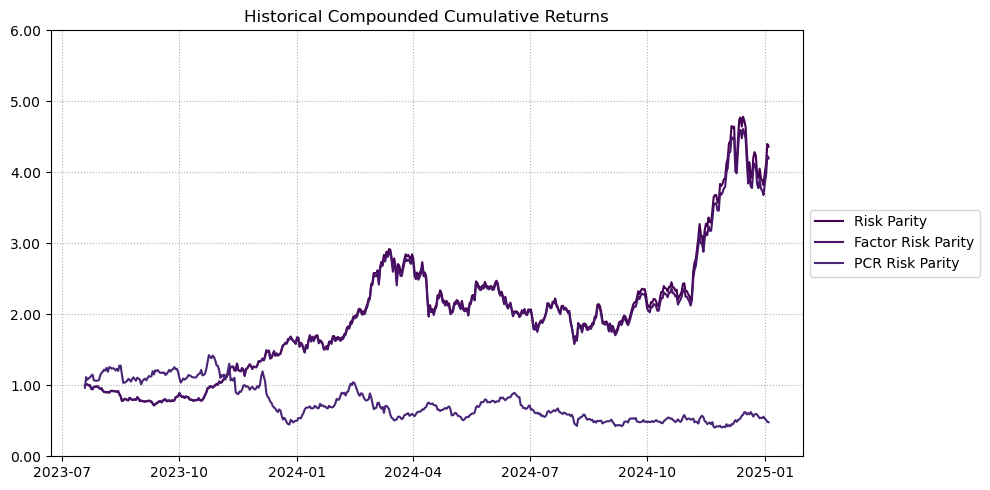

In [10]:
import numpy as np
import pandas as pd
import riskfolio as rp
from datetime import datetime, timedelta
from typing import List, Union, Dict, Tuple, Optional

class PortfolioOptimizer:
    def __init__(self, config: Dict):
        """
        Initialize the Portfolio Optimizer with configuration parameters.
        
        Args:
            config (Dict): Configuration dictionary containing model parameters
        """
        self.config = config
        self.portfolio = None
        self.X = None  # Factor data
        self.Y = None  # Returns data

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess the input dataframe by handling missing values, infinities,
        and converting percentages to decimals.
        
        Args:
            df (pd.DataFrame): Input dataframe with financial data
            
        Returns:
            pd.DataFrame: Preprocessed dataframe
        """
        df = df.copy()

        # Convert index to datetime
        df.index = pd.to_datetime(df.index)

        # Convert percentage values to decimals if needed
        if df.mean().mean() > 1:
            df = df / 100

        # Replace infinite values
        df = df.replace([np.inf, -np.inf], np.nan)

        # Handle missing values
        df = df.fillna(method='ffill').fillna(method='bfill')

        # Resample to daily frequency
        df = df.resample('D').last().fillna(method='ffill')

        return df

    def align_data(self, factors: pd.DataFrame, returns: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Align factor and returns data to have matching dates.
        
        Args:
            factors (pd.DataFrame): Factor returns data
            returns (pd.DataFrame): Asset returns data
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: Aligned factor and returns data
        """
        common_dates = factors.index.intersection(returns.index)
        return factors.loc[common_dates], returns.loc[common_dates]

    def prepare_data(self, returns_data: pd.DataFrame, factors_data: Optional[pd.DataFrame] = None) -> None:
        """
        Prepare the data for portfolio optimization.
        
        Args:
            returns_data (pd.DataFrame): Asset returns data
            factors_data (Optional[pd.DataFrame]): Factor returns data
        """
        self.Y = self.preprocess_data(returns_data)

        if factors_data is not None:
            self.X = self.preprocess_data(factors_data)
            self.X, self.Y = self.align_data(self.X, self.Y)

        self.portfolio = rp.Portfolio(returns=self.Y)

        # Set display format for percentages
        pd.options.display.float_format = '{:.4%}'.format

        # Calculate basic statistics
        self.portfolio.assets_stats(
            method_mu=self.config['expected_returns_method'],
            method_cov=self.config['covariance_method']
        )

    def optimize_sharpe_ratio(self) -> pd.Series:
        """
        Optimize portfolio weights to maximize the Sharpe ratio.
        
        Returns:
            pd.Series: Optimal portfolio weights
        """
        return self.portfolio.optimization(
            model=self.config['model_type'],
            rm=self.config['risk_measure'],
            obj='Sharpe',
            rf=self.config['risk_free_rate'],
            l=self.config['risk_aversion'],
            hist=self.config['use_hist']
        )

    def calculate_efficient_frontier(self) -> pd.DataFrame:
        """
        Calculate the efficient frontier points.
        
        Returns:
            pd.DataFrame: Efficient frontier points
        """
        return self.portfolio.efficient_frontier(
            model=self.config['model_type'],
            rm=self.config['risk_measure'],
            points=self.config['ef_points'],
            rf=self.config['risk_free_rate'],
            hist=self.config['use_hist']
        )

    def optimize_risk_parity(self) -> pd.Series:
        """
        Optimize portfolio weights using risk parity approach.
        
        Returns:
            pd.Series: Risk parity portfolio weights
        """
        return self.portfolio.rp_optimization(
            model=self.config['model_type'],
            rm=self.config['risk_measure'],
            rf=self.config['risk_free_rate'],
            b=None,
            hist=self.config['use_hist']
        )

    def optimize_factor_risk_parity(self) -> pd.Series:
        """
        Optimize portfolio weights using factor risk parity approach.
        
        Returns:
            pd.Series: Factor risk parity portfolio weights
        """
        if self.X is None:
            raise ValueError("Factor data not provided. Cannot perform factor risk parity optimization.")

        self.portfolio.factors = self.X
        self.portfolio.factors_stats(
            method_mu=self.config['expected_returns_method'],
            method_cov=self.config['covariance_method']
        )

        return self.portfolio.rp_optimization(
            model='FM',
            rm='MV',
            rf=self.config['risk_free_rate'],
            b_f=None
        )

    def optimize_pcr_risk_parity(self) -> pd.Series:
        """
        Optimize portfolio weights using principal component risk parity approach.
        
        Returns:
            pd.Series: PCR risk parity portfolio weights
        """
        if self.X is None:
            raise ValueError("Factor data not provided. Cannot perform PCR risk parity optimization.")

        self.portfolio.factors = self.X
        self.portfolio.factors_stats(
            method_mu=self.config['expected_returns_method'],
            method_cov=self.config['covariance_method'],
            feature_selection='PCR'
        )

        return self.portfolio.rp_optimization(
            model='FC',
            rm='MV',
            rf=self.config['risk_free_rate'],
            b_f=None
        )

class PortfolioPlotter:
    """
    A class to handle all plotting functionality for portfolio optimization results.
    """
    def __init__(self, returns: pd.DataFrame, portfolio: rp.Portfolio):
        self.returns = returns
        self.portfolio = portfolio

    def plot_series(self, weights: pd.DataFrame, height: int = 5, width: int = 10) -> None:
        """Plot portfolio return series."""
        return rp.plot_series(
            returns=self.returns,
            w=weights,
            cmap='viridis',
            height=height,
            width=width,
            ax=None
        )

    def plot_frontier(self, weights_frontier: pd.DataFrame, weights: pd.Series,
                      expected_returns: pd.Series, covariance: pd.DataFrame,
                      risk_measure: str, risk_free_rate: float, alpha: float,
                      label: str = 'Max Risk Adjusted Return Portfolio',
                      height: int = 6, width: int = 10) -> None:
        """Plot efficient frontier."""
        return rp.plot_frontier(
            w_frontier=weights_frontier,
            mu=expected_returns,
            cov=covariance,
            returns=self.returns,
            rm=risk_measure,
            rf=risk_free_rate,
            alpha=alpha,
            cmap='viridis',
            w=weights,
            label=label,
            marker='*',
            s=16,
            c='r',
            height=height,
            width=width,
            t_factor=252,
            ax=None
        )

    def plot_pie(self, weights: pd.Series, title: str = 'Portfolio',
                 height: int = 6, width: int = 10) -> None:
        """Plot portfolio weights as a pie chart."""
        return rp.plot_pie(
            w=weights,
            title=title,
            height=height,
            width=width,
            cmap="tab20",
            ax=None
        )

    def plot_bar(self, weights: pd.Series, title: str = 'Portfolio',
                 height: int = 6, width: int = 10) -> None:
        """Plot portfolio weights as a bar chart."""
        return rp.plot_bar(
            weights,
            title=title,
            kind="v",
            others=0.05,
            nrow=25,
            height=height,
            width=width,
            ax=None
        )

    def plot_hist(self, weights: pd.Series, alpha: float = 0.05,
                  height: int = 6, width: int = 10) -> None:
        """Plot portfolio returns distribution."""
        return rp.plot_hist(
            returns=self.returns,
            w=weights,
            alpha=alpha,
            bins=50,
            height=height,
            width=width,
            ax=None
        )

    def plot_drawdown(self, weights: pd.Series, alpha: float = 0.05,
                      height: int = 8, width: int = 10) -> None:
        """Plot portfolio drawdown."""
        return rp.plot_drawdown(
            returns=self.returns,
            w=weights,
            alpha=alpha,
            height=height,
            width=width,
            ax=None
        )

    def plot_clusters(self, height: int = 8, width: int = 10) -> None:
        """Plot asset clusters."""
        return rp.plot_clusters(
            returns=self.returns,
            codependence='spearman',
            linkage='ward',
            k=None,
            max_k=10,
            leaf_order=True,
            dendrogram=True,
            ax=None
        )

    def plot_network(self, height: int = 8, width: int = 10) -> None:
        """Plot asset network."""
        return rp.plot_network(
            returns=self.returns,
            codependence="pearson",
            linkage="ward",
            k=None,
            max_k=10,
            alpha_tail=0.05,
            leaf_order=True,
            kind='kamada',
            ax=None
        )

# Risk Measures Available:

# Variance-Based Measures:
# 'MV' - Standard Deviation # Traditional measure for normally distributed returns, considers both upside/downside
# 'MSV' - Semi Standard Deviation # Only negative deviations, better for asymmetric distributions

# Absolute Deviation Measures:
# 'MAD' - Mean Absolute Deviation # Less sensitive to outliers than SD, good for frequent small/medium deviations

# Lower Partial Moments:
# 'FLPM' - First Lower Partial Moment (Omega Ratio) # Measures expected shortfall below target return
# 'SLPM' - Second Lower Partial Moment (Sortino Ratio) # Like FLPM but penalizes larger shortfalls more heavily

# Value at Risk (VaR) Based:
# 'CVaR' - Conditional Value at Risk # Expected loss exceeding VaR, good for fat-tailed distributions
# 'EVaR' - Entropic Value at Risk # More conservative than CVaR, for extreme uncertainty

# Drawdown-Based Measures:
# 'WR' - Worst Realization (Minimax) # Most conservative, focuses on worst possible outcome
# 'MDD' - Maximum Drawdown # Largest peak-to-trough decline, crucial for volatile markets
# 'ADD' - Average Drawdown # Average size of all drawdowns, for typical drawdown behavior
# 'CDaR' - Conditional Drawdown at Risk # Similar to CVaR but for drawdowns, good for extended downturns
# 'EDaR' - Entropic Drawdown at Risk # Conservative version of CDaR
# 'RlDaR' - Relative Drawdown at Risk # Drawdowns relative to peak, good for strategy comparison
# 'UCI' - Ulcer Index # Combines depth and duration of drawdowns, good for prolonged drawdown evaluation

# Usage Guide:
# - For normal markets: MV, MAD
# - For asymmetric returns: MSV, FLPM, SLPM
# - For fat-tailed distributions (e.g., crypto): CVaR, EVaR
# - For drawdown-sensitive strategies: MDD, CDaR, UCI, ADD
# - For extreme risk aversion: WR, EDaR
# - For relative performance analysis: RlDaR
# - For extended downturns: CDaR, UCI

config = {
    'start': '2017-01-01',
    'end': '2025-12-01',
    'model_type': 'Classic',  # Consider using 'BL' for Black-Litterman model
    'objective_function': 'Sharpe',
    'risk_measure': 'CVaR',  # Changed to Conditional Drawdown at Risk
    'risk_free_rate': 0.03,  # Updated to reflect current environment
    'risk_aversion': 0.25,   # Added risk aversion parameter
    'use_hist': True,
    'expected_returns_method': 'hist',  # Changed to exponentially weighted
    'covariance_method': 'hist',       # Changed to exponentially weighted
    'alpha': 0.05,
    'ef_points': 50,         # Increased for better frontier resolution
    'window': 252,           # Added rolling window parameter
    'decay_factor': 0.94,    # Added decay factor for EWM
}

# Initialize optimizer
optimizer = PortfolioOptimizer(config)

# List of symbols you want to analyze
symbols = [
    # 'BINANCE:ENAUSDT',
    'BINANCE:COMPUSDT',
    'BINANCE:LINKUSDT',
    'BINANCE:ADAUSDT',
    'BINANCE:ARKMUSDT',
    'BINANCE:AAVEUSDT',
    'BINANCE:SOLUSDT',
    'BINANCE:SUIUSDT',
    "BINANCE:BTCUSDT",
    "BINANCE:ETHUSDT",
    'BINANCE:ATOMUSDT'
    # ("BINANCE", "BNBUSDT")  # Alternative tuple format
]

factors = [
    # General factors
    'CBOE:MTUM',
    'CBOE:QUAL',
    'CBOE:VLUE',
    'AMEX:SIZE',
    'CBOE:USMV',

    # # Crypto factors
    'CRYPTOCAP:BTC.D',
    'CRYPTOCAP:ETH.D',
    'CRYPTOCAP:TOTALDEFI',
    # 'CRYPTOCAP:DEFIETH',
    'OTC:BITW',
    # 
    # # Macro factors
    # 'AMEX:GLD',            # Gold (inflation hedge)
    # 
    # # Volatility
    'CBOE:VIX',            # Traditional market volatility
    
]

# Initialize MarketDataManager
mdm = MarketDataManager()
# Get symbol returns matrix
df_returns = mdm.get_returns_matrix(
    symbols=symbols,
    start_date=datetime.now() - timedelta(days=5000)
).dropna()
# rename index to Date
df_returns.index.name = 'Date'

# Get factor returns matrix
df_factors = mdm.get_returns_matrix(
    symbols=factors,
    start_date=datetime.now() - timedelta(days=5000)
).dropna()
# rename index to Date
df_factors.index.name = 'Date'
# Normalize factors with z-score
df_factors = (df_factors - df_factors.mean()) / df_factors.std()

# Prepare data (assuming df_returns and df_factors are your data)
optimizer.prepare_data(returns_data=df_returns, factors_data=df_factors)

# Get different portfolio optimizations
weights_sharpe = optimizer.optimize_sharpe_ratio()
weights_risk_parity = optimizer.optimize_risk_parity()
weights_factor_rp = optimizer.optimize_factor_risk_parity()
weights_pcr_rp = optimizer.optimize_pcr_risk_parity()
efficient_frontier = optimizer.calculate_efficient_frontier()

models = ['Sharpe Ratio', 'Risk Parity', 'Factor Risk Parity', 'PCR Risk Parity']
weights = [weights_sharpe, weights_risk_parity, weights_factor_rp, weights_pcr_rp]
weights_df = pd.DataFrame()
successful_models = []  # Keep track of successful models

while len(weights) > 0:
    if weights[0] is None:
        print(f"Optimization Model: {models[0]} got no results")
    else:
        weights_df = pd.concat([weights_df, weights[0]], axis=1)
        successful_models.append(models[0])  # Store the model name if weights exist

    models.pop(0)
    weights.pop(0)

weights_df.columns = successful_models
        
# Initialize plotter
plotter = PortfolioPlotter(returns=df_returns, portfolio=optimizer.portfolio)

# Plot the series
plotter.plot_series(weights_df)
# plotter.plot_series(efficient_frontier)
# plotter.plot_clusters()

<Axes: title={'center': 'Minimun Spanning Tree (Pearson, ward linkage & kamada layout)'}>

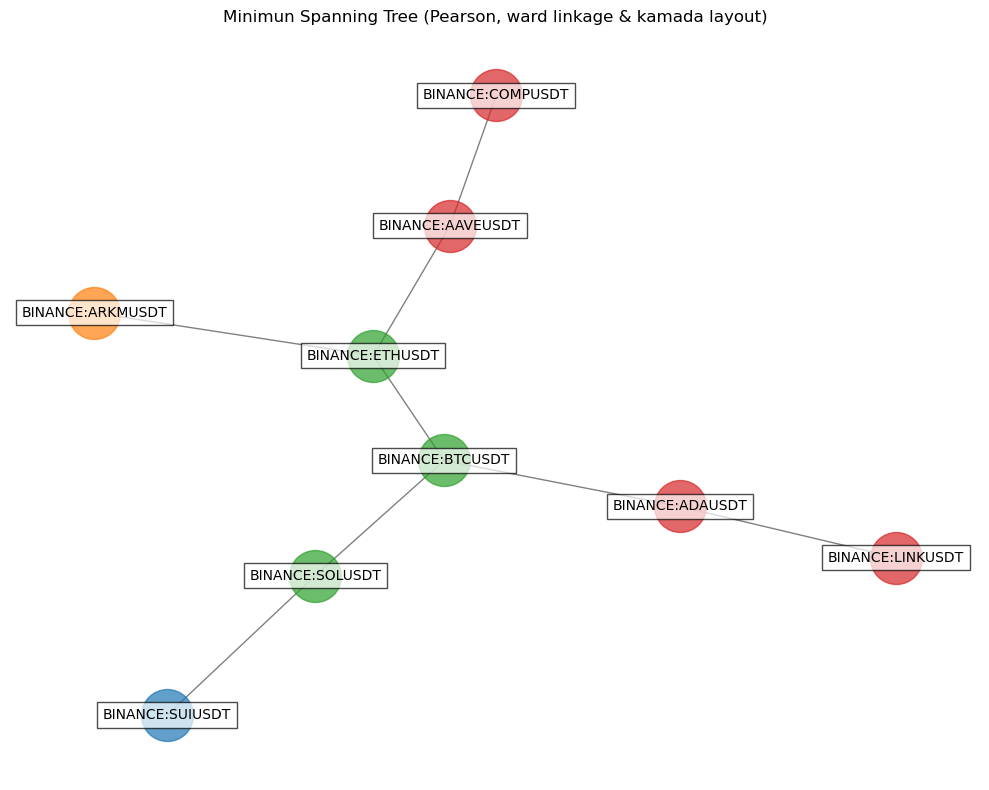

In [4]:
plotter.plot_network()

/opt/anaconda3/envs/pyfi/lib/python3.8/site-packages/cvxpy/problems/problem.py:1407: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.



array([<Axes: title={'center': 'Historical Compounded Cumulative Returns'}>,
       <Axes: title={'center': 'Historical Uncompounded Drawdown'}>],
      dtype=object)

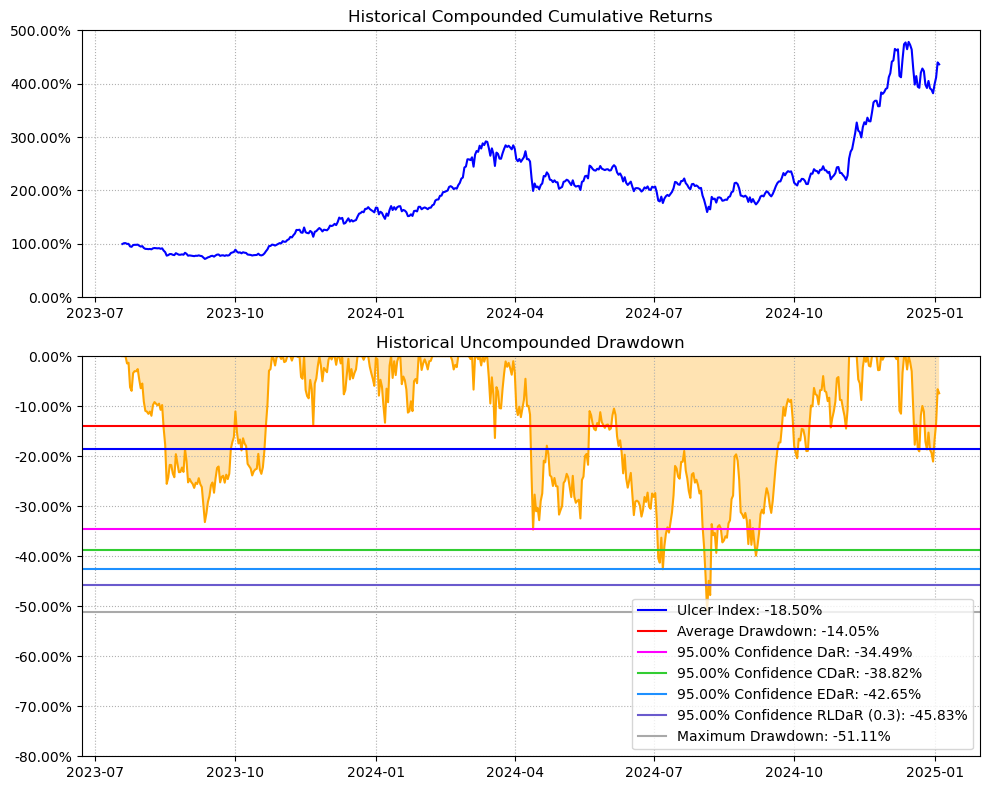

In [5]:
weights_risk_parity = optimizer.optimize_risk_parity()
plotter = PortfolioPlotter(returns=df_returns, portfolio=optimizer.portfolio)

# Plot the series
# plotter.plot_series(weights_risk_parity)
plotter.plot_drawdown(weights_risk_parity)

<Axes: title={'center': 'Portfolio Returns Histogram'}, ylabel='Probability Density'>

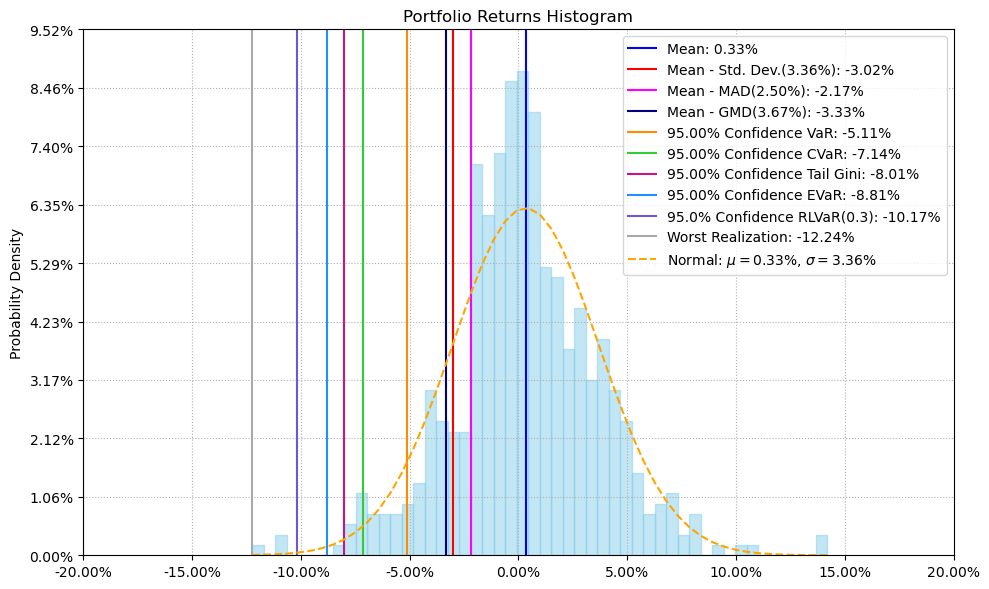

In [6]:
plotter.plot_hist(weights_risk_parity)

<Axes: title={'center': 'Portfolio'}>

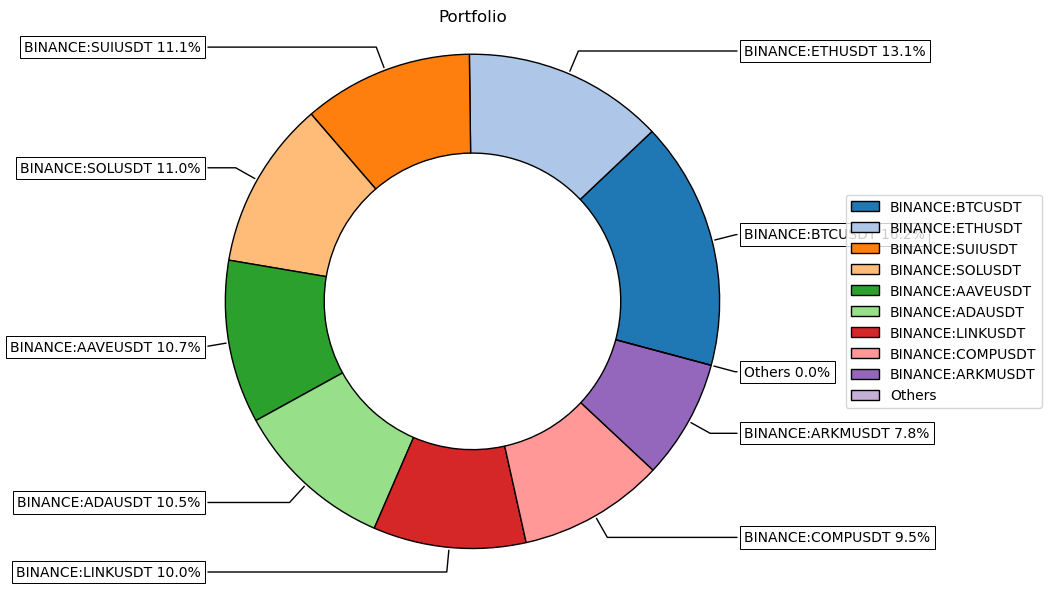

In [7]:
# Plot the rest of the visualizations
plotter.plot_pie(weights_risk_parity)
# plotter.plot_bar(weights_risk_parity)


In [11]:
config = {
    # Date range
    'start': '2017-01-01',
    'end': '2025-12-01',
    # Model configuration
    'model_type': 'Classic', # Classic (historical), BL (Black Litterman), FM (Factor Model), BLFM (BL with FM)
    'objective_function': 'Sharpe', # MinRisk, MaxRet, Utility, Sharpe
    'risk_measure': 'CDaR',
    # Risk measure parameters
    'risk_free_rate': 0.0, # Risk-free rate
    'risk_aversion': 0, # Risk aversion factor, only useful with obj function 'Utility'
    # Estimate inputs of the model (historical estimates)
    'use_hist' : True, # Use historical scenarios for risk measures based on those scenarios. Hist is only for FM and BLFM
    'expected_returns_method': 'hist',
    'covariance_method': 'hist',

    'alpha': 0.05, # Significance level for CVaR and MAD

    # Efficient frontier
    'ef_points': 20, # Number of points of the efficient frontier
}

# Initialize MarketDataManager
mdm = MarketDataManager()

# Get symbol returns matrix
df_returns = mdm.get_returns_matrix(
    symbols=symbols,
    start_date=datetime.now() - timedelta(days=1000)
).dropna()
# rename index to Date
df_returns.index.name = 'Date'

# Get factor returns matrix
df_factors = mdm.get_returns_matrix(
    symbols=factors,
    start_date=datetime.now() - timedelta(days=1000)
).dropna()
# rename index to Date
df_factors.index.name = 'Date'

# First let's start with the original data
X = df_factors.copy()
Y = df_returns.copy()

# Convert index to datetime first
X.index = pd.to_datetime(X.index)
Y.index = pd.to_datetime(Y.index)

# Convert percentage values to decimals if needed
if X.mean().mean() > 1:
    X = X / 100
if Y.mean().mean() > 1:
    Y = Y / 100

# Replace any infinite values
X = X.replace([np.inf, -np.inf], np.nan)
Y = Y.replace([np.inf, -np.inf], np.nan)

# Fill NaN values using forward fill then backward fill
X = X.fillna(method='ffill').fillna(method='bfill')
Y = Y.fillna(method='ffill').fillna(method='bfill')

# Resample to daily and fill any gaps
X = X.resample('D').last().fillna(method='ffill')
Y = Y.resample('D').last().fillna(method='ffill')

# Align the dates between X and Y
common_dates = X.index.intersection(Y.index)
X = X.loc[common_dates]
Y = Y.loc[common_dates]

# Standardize the factor data
# X = (X - X.mean()) / X.std()


# Creating the Portfolio Object
portfolio = rp.Portfolio(returns=Y)

# To display dataframes values in percentage format
pd.options.display.float_format = '{:.4%}'.format

# Estimate expected returns and covariance matrix
portfolio.assets_stats(method_mu=config['expected_returns_method'], method_cov=config['covariance_method'])

# Calculate the portfolio performance and risk measures
expected_returns = portfolio.mu # Expected returns
covariance_matrix = portfolio.cov # Covariance matrix
alpha = config['alpha'] # Significance level for CVaR and MAD

# Estimate the portfolio that maximizes the risk adjusted return ratio
portfolio_weights1 = portfolio.optimization(model='Classic', rm=config['risk_measure'],
                                            obj='Sharpe', rf=config['risk_free_rate'], l=config['risk_aversion'], hist=config['use_hist'])

# Estimate points in the efficient frontier mean - semi standard deviation
portfolio_frontier = portfolio.efficient_frontier(model='Classic', rm=config['risk_measure'],
                                                  points=config['ef_points'], rf=config['risk_free_rate'], hist=config['use_hist'])

# Estimate the risk parity portfolio for semi standard deviation
portfolio_weights2 = portfolio.rp_optimization(model='Classic', rm=config['risk_measure'], rf=config['risk_free_rate'], b=None, hist=config['use_hist'])

# Estimate the risk parity portfolio for risk factors
portfolio.factors = X
portfolio.factors_stats(method_mu=config['expected_returns_method'],
                        method_cov=config['covariance_method'],
                        # feature_selection='stepwise',
                        # stepwise='Forward', solver='SLSQP'
                        )

portfolio_weights3 = portfolio.rp_optimization(model='FM', rm='MV', rf=config['risk_free_rate'], b_f=None)

# Estimate the risk parity portfolio for principal components
portfolio.factors = X
portfolio.factors_stats(method_mu=config['expected_returns_method'],
                        method_cov=config['covariance_method'],
                        feature_selection='PCR',
                        # n_components=0.95
                        )

portfolio_weights4 = portfolio.rp_optimization(model='FC', rm='MV', rf=config['risk_free_rate'], b_f=None)

you are using nologin method, data you access may be limited


In [12]:
# concat weights from all portfolios
portfolio_weights = pd.concat([portfolio_weights1, portfolio_weights2, portfolio_weights3, portfolio_weights4], axis=1)
portfolio_weights.columns = ['Max Risk Adjusted Return Portfolio', 'Risk Parity Portfolio (Semi Std)', 'Risk Parity Portfolio (Factors)', 'Risk Parity Portfolio (Principal Components)']
portfolio_weights

,Max Risk Adjusted Return Portfolio,Risk Parity Portfolio (Semi Std),Risk Parity Portfolio (Factors),Risk Parity Portfolio (Principal Components)
BINANCE:COMPUSDT,0.0000%,6.5193%,9.9638%,-14.9692%
BINANCE:LINKUSDT,0.0000%,7.7034%,10.1730%,59.1012%
BINANCE:ADAUSDT,0.0000%,6.2176%,11.1269%,-72.3710%
BINANCE:ARKMUSDT,0.0000%,5.8988%,7.3274%,-31.3685%
BINANCE:AAVEUSDT,4.2551%,16.1844%,10.0145%,-29.4736%
BINANCE:SOLUSDT,36.3551%,16.6294%,10.3397%,-71.9188%
BINANCE:SUIUSDT,0.0000%,5.8160%,9.3850%,19.0957%
BINANCE:BTCUSDT,59.3897%,21.0570%,17.5828%,157.0722%
BINANCE:ETHUSDT,0.0000%,13.9741%,14.0870%,84.8319%


In [13]:
risk_metrics = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR', 'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'EDaR', 'UCI']
# portfolio.solvers = ['MOSEK', 'XPRESS']

weights_combined = pd.DataFrame([])

for metric in risk_metrics:
    print(f'Optimizing for {metric}')
    portfolio_weights = portfolio.optimization(model=config['model_type'], rm=metric,
                                               obj=config['objective_function'], rf=config['risk_free_rate'],
                                               l=config['risk_aversion'], hist=config['use_hist'])
    weights_combined = pd.concat([weights_combined, portfolio_weights], axis=1)

weights_combined.columns = risk_metrics

weights_combined.style.format("{:.2%}").background_gradient(cmap='viridis', axis=0)

Optimizing for MV
Optimizing for MAD
Optimizing for MSV
Optimizing for FLPM
Optimizing for SLPM
Optimizing for CVaR
Optimizing for EVaR
Optimizing for WR
Optimizing for MDD
Optimizing for ADD
Optimizing for CDaR
Optimizing for EDaR
Optimizing for UCI


,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,EDaR,UCI
BINANCE:COMPUSDT,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BINANCE:LINKUSDT,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BINANCE:ADAUSDT,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BINANCE:ARKMUSDT,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BINANCE:AAVEUSDT,14.38%,12.53%,9.30%,15.02%,8.84%,2.96%,0.00%,0.00%,3.62%,19.44%,4.26%,4.38%,14.77%
BINANCE:SOLUSDT,37.80%,28.12%,39.65%,24.61%,41.70%,63.68%,50.90%,20.15%,38.28%,22.83%,36.36%,38.08%,20.37%
BINANCE:SUIUSDT,17.01%,14.78%,23.72%,17.16%,24.71%,33.36%,15.79%,13.17%,0.00%,0.00%,0.00%,0.00%,0.00%
BINANCE:BTCUSDT,30.80%,44.58%,27.33%,43.21%,24.75%,0.00%,33.32%,66.68%,58.11%,57.74%,59.39%,57.54%,64.86%
BINANCE:ETHUSDT,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


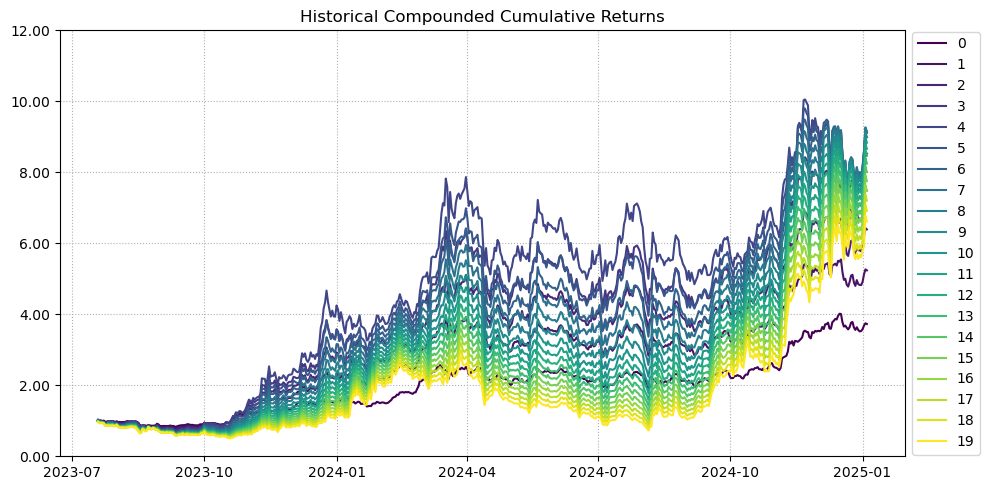

In [14]:
ax = rp.plot_series(returns=Y,
                    w=portfolio_frontier,
                    cmap='viridis',
                    height=5,
                    width=10,
                    ax=None)

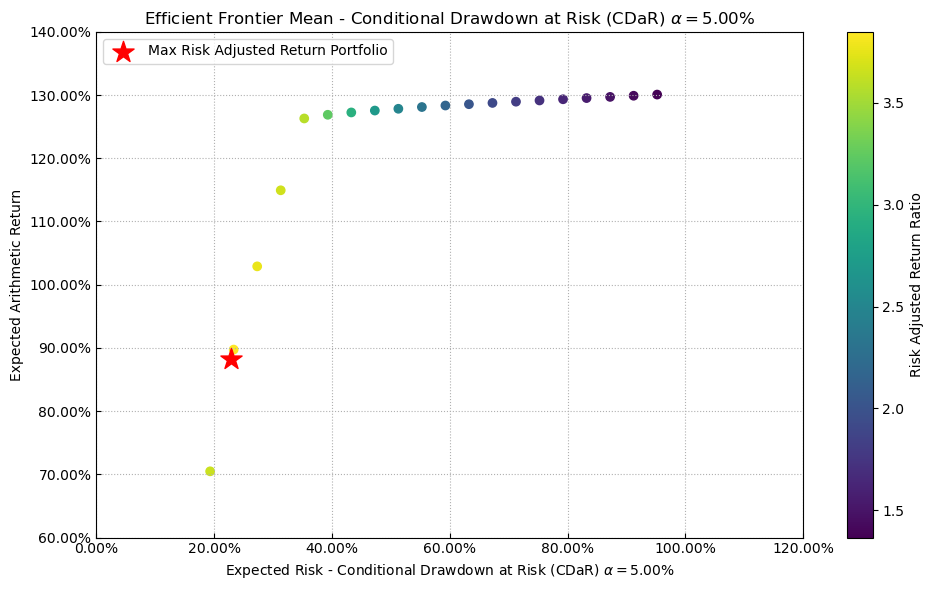

In [15]:
label = 'Max Risk Adjusted Return Portfolio'
returns = portfolio.returns

ax = rp.plot_frontier(w_frontier=portfolio_frontier,
                      mu=expected_returns,
                      cov=covariance_matrix,
                      returns=Y,
                      rm=config['risk_measure'],
                      rf=config['risk_free_rate'],
                      alpha=config['alpha'],
                      cmap='viridis',
                      w=portfolio_weights1,
                      label=label,
                      marker='*',
                      s=16,
                      c='r',
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

In [16]:
portfolio_frontier

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
BINANCE:COMPUSDT,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
BINANCE:LINKUSDT,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
BINANCE:ADAUSDT,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
BINANCE:ARKMUSDT,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
BINANCE:AAVEUSDT,8.8942%,4.5115%,3.5430%,2.3428%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
BINANCE:SOLUSDT,5.0397%,38.6091%,60.3469%,80.4044%,98.8970%,83.6563%,74.0086%,66.1307%,58.7997%,51.5793%,45.2946%,39.8834%,34.6017%,29.4540%,24.3972%,19.4031%,14.4839%,9.6354%,4.8032%,0.0004%
BINANCE:SUIUSDT,0.0000%,0.0000%,0.0000%,0.0000%,1.1030%,16.3437%,25.9914%,33.8693%,41.2003%,48.4207%,54.7054%,60.1166%,65.3983%,70.5460%,75.6028%,80.5969%,85.5161%,90.3646%,95.1968%,99.9996%
BINANCE:BTCUSDT,86.0661%,56.8794%,36.1101%,17.2528%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
BINANCE:ETHUSDT,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


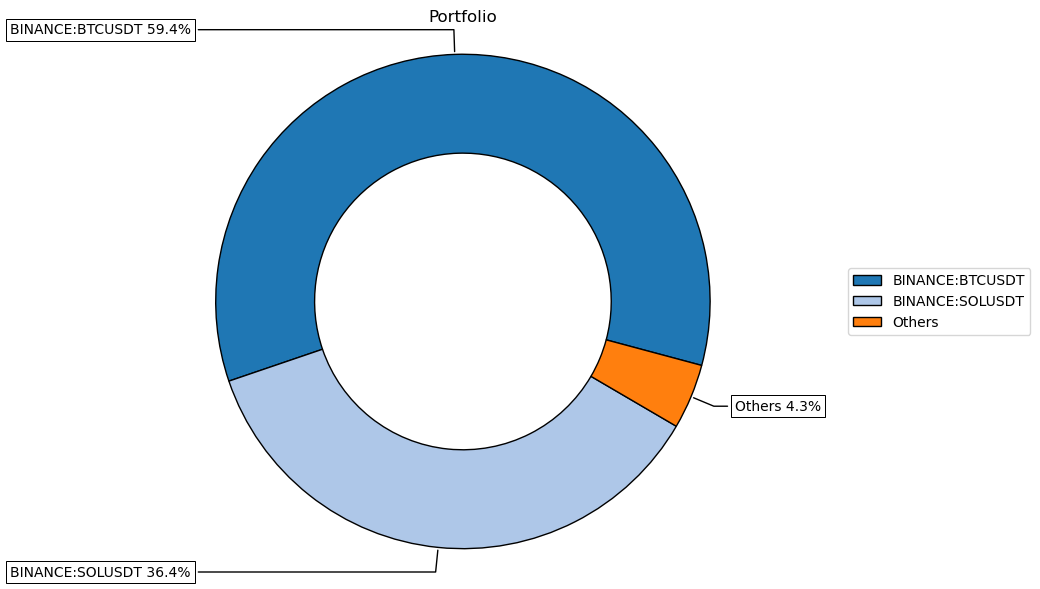

In [17]:
ax = rp.plot_pie(w=portfolio_weights1,
                 title='Portfolio',
                 height=6,
                 width=10,
                 cmap="tab20",
                 ax=None)

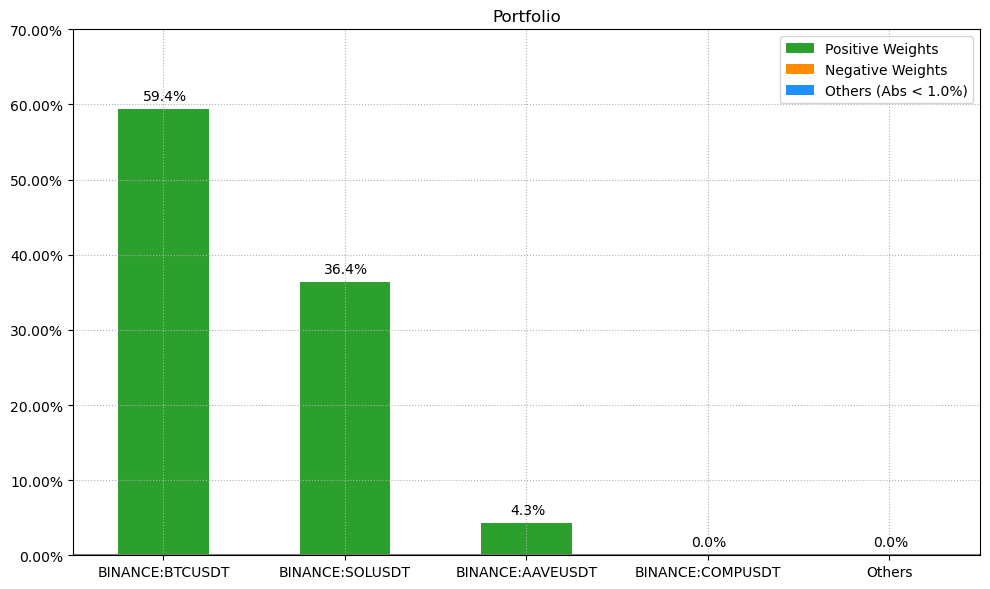

In [18]:
ax = rp.plot_bar(portfolio_weights1,
                 title='Portfolio',
                 kind="v",
                 others=0.05,
                 nrow=25,
                 height=6,
                 width=10,
                 ax=None)

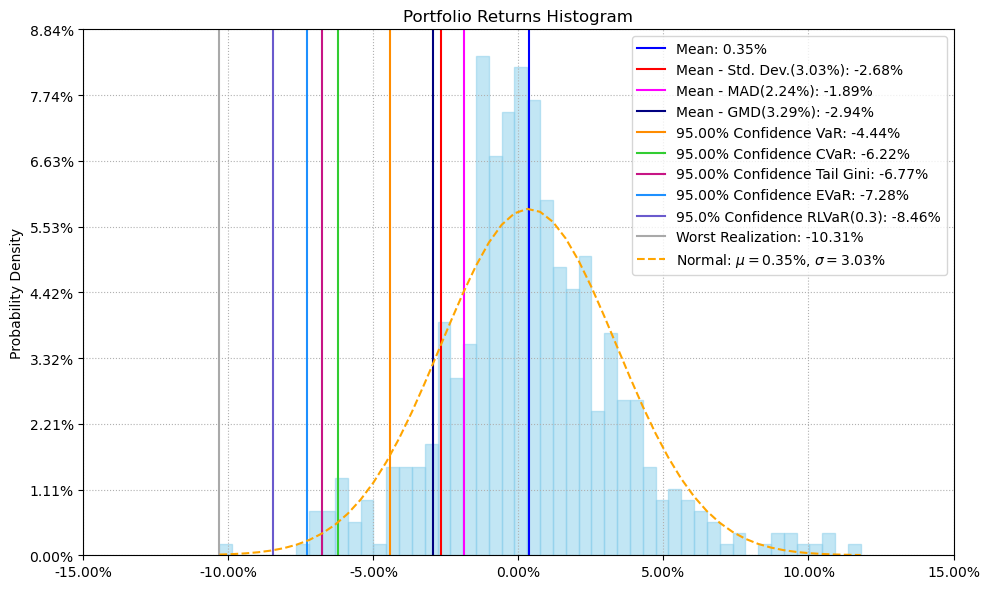

In [19]:
ax = rp.plot_hist(returns=Y,
                  w=portfolio_weights1,
                  alpha=0.05,
                  bins=50,
                  height=6,
                  width=10,
                  ax=None)

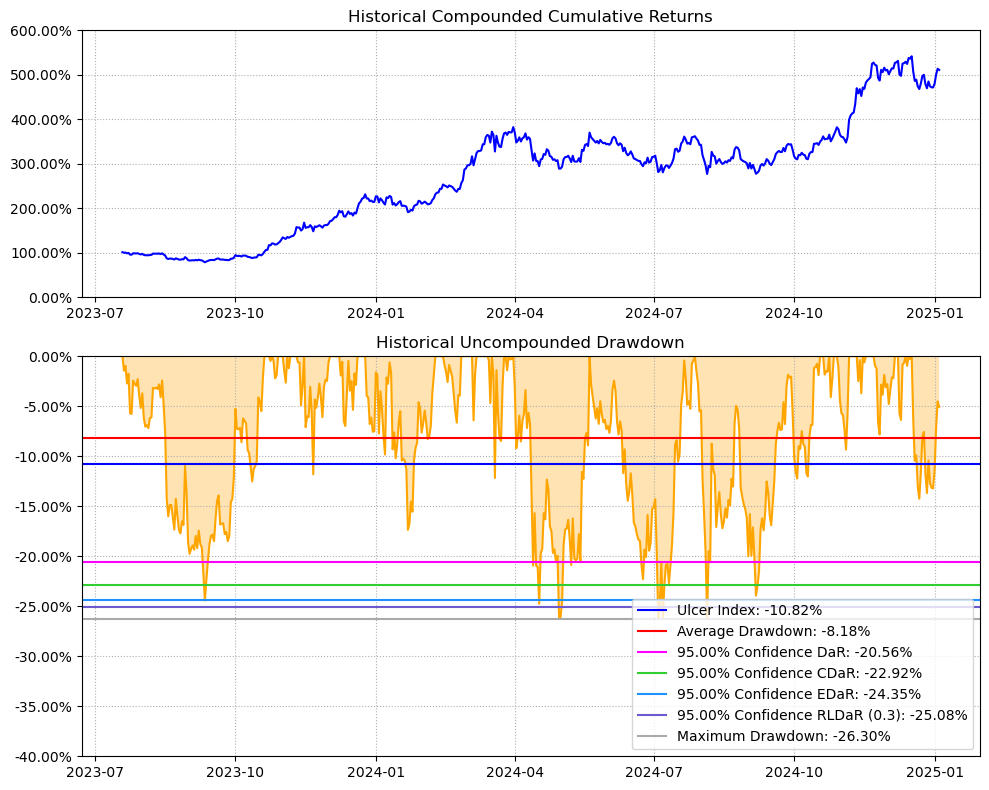

In [20]:
ax = rp.plot_drawdown(returns=Y,
                      w=portfolio_weights1,
                      alpha=0.05,
                      height=8,
                      width=10,
                      ax=None)

/opt/anaconda3/envs/pyfi/lib/python3.8/site-packages/riskfolio/src/PlotFunctions.py:2895: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



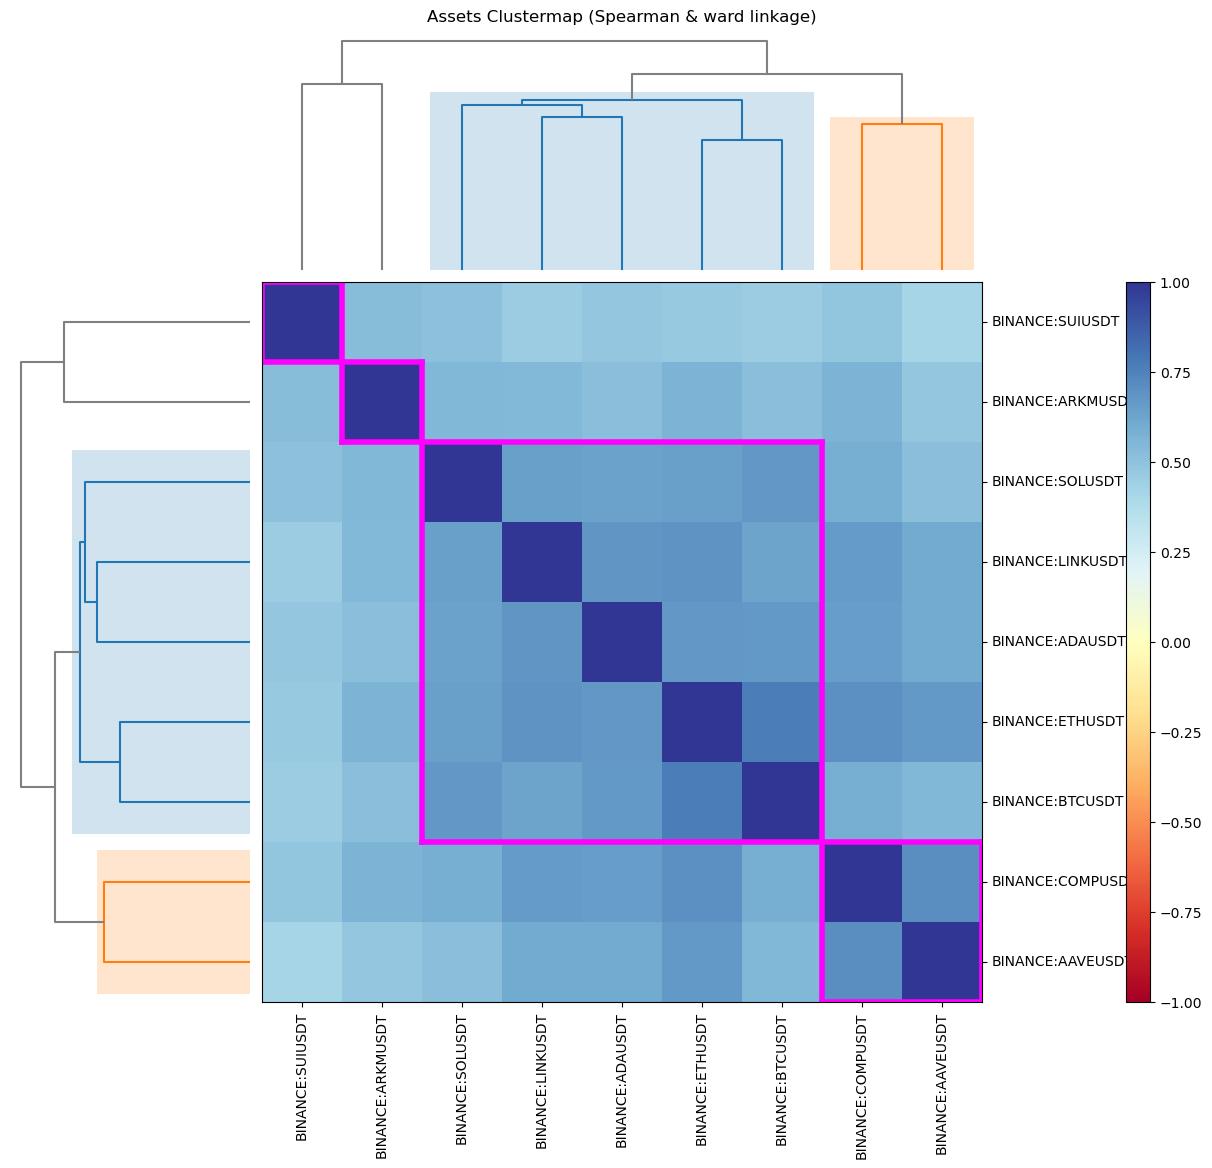

In [21]:
ax = rp.plot_clusters(returns=Y,
                      codependence='spearman',
                      linkage='ward',
                      k=None,
                      max_k=10,
                      leaf_order=True,
                      dendrogram=True,
                      ax=None)


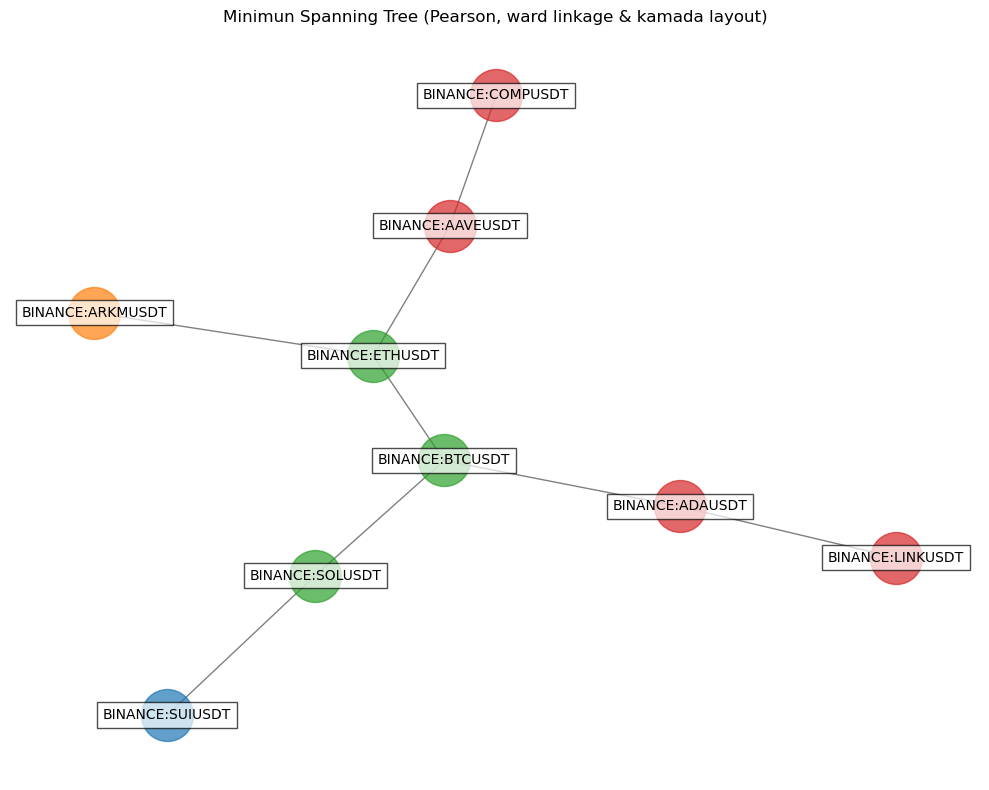

In [22]:
ax = rp.plot_network(returns=Y,
                     codependence="pearson",
                     linkage="ward",
                     k=None,
                     max_k=10,
                     alpha_tail=0.05,
                     leaf_order=True,
                     kind='kamada',
                     ax=None)